### Deep Learning Exam [PGR207] ###

Task 1: Models

Candidate 2036

In [ ]:
import os
import requests
import tarfile
import zipfile
import torch
import torchvision
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torchvision.datasets import VisionDataset
from torchvision.io import read_image
from torchvision.utils import make_grid
from torch.optim.lr_scheduler import StepLR
from PIL import Image

**Device**

In [ ]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


**Download Dataset**

In [ ]:
class KvasirInstrument(VisionDataset):
  URL = "https://datasets.simula.no/downloads/kvasir-instrument.zip"
  BASE_FOLDER = "kvasir-instrument"
  IMAGES_FOLDER = "images"
  MASKS_FOLDER = "masks"

  def __init__(self, root, train=True, transform=None,target_transform=None, download=False):
    super().__init__(root, transform=transform)
    # Add target_transform for masks
    self.target_transform = target_transform
    if download:
      self.download()

    if not self._check_exists():
      raise RuntimeError('Dataset not found. Use download=True to download it.')

    data_file = "train.txt" if train else "test.txt"
    with open(os.path.join(root, self.BASE_FOLDER, data_file), "r") as f:
      self.images = [img.strip() for img in f.readlines()]

  def _check_exists(self):
    return os.path.exists(os.path.join(self.root, self.BASE_FOLDER, self.IMAGES_FOLDER))

  def download(self):
    if self._check_exists():
      return

    os.makedirs(self.root, exist_ok=True)

    r = requests.get(self.URL, allow_redirects=True)
    with open(os.path.join(self.root, "kvasir-instrument.zip"), 'wb') as f:
      f.write(r.content)

    with zipfile.ZipFile(os.path.join(self.root, "kvasir-instrument.zip"), 'r') as zip_ref:
      zip_ref.extractall(self.root)

    # extract images and masks from images.tar.gz and masks.tar.gz
    for tar_file in ["images.tar.gz", "masks.tar.gz"]:
        with tarfile.open(os.path.join(self.root, self.BASE_FOLDER, tar_file), 'r:gz') as tar_ref:
            tar_ref.extractall(os.path.join(self.root, self.BASE_FOLDER))

  def __getitem__(self, index):
    image_name = self.images[index]
    image_path = os.path.join(self.root, self.BASE_FOLDER, self.IMAGES_FOLDER, image_name + ".jpg")
    mask_path = os.path.join(self.root, self.BASE_FOLDER, self.MASKS_FOLDER, image_name + ".png")

    image = Image.open(image_path)
    mask = Image.open(mask_path)
    mask = mask.convert('L') # Convert mask to grayscale to ensure it's single channel
    # Ensure transforms are applied synchronously
    if self.transform:
      image = self.transform(image)
    if self.target_transform:
      mask = self.target_transform(mask)

    # After the transformations
    mask = mask.unsqueeze(0)  # Adding channel dimension

    return image, mask

  def __len__(self):
    return len(self.images)

In [ ]:
# Define the transform with resize, then transfer to tensor
image_transform = transforms.Compose([
    transforms.Resize((576, 720)),
    transforms.ToTensor(),
])

mask_transform = transforms.Compose([
    transforms.Resize((576, 720)),
    transforms.ToTensor(),
    lambda x: (x > 0.5).float()
])

# Apply the transorm to the datasets
training_data = KvasirInstrument(root="data", train=True, download=True, transform=image_transform, target_transform=mask_transform)
test_data = KvasirInstrument(root="data", train=False, download=True, transform=image_transform, target_transform=mask_transform)
# Create the DataLoaders
train_loader = DataLoader(training_data, batch_size=4, shuffle=True) # batch size while testing is set to 1 / increase as desired
test_loader = DataLoader(test_data, batch_size=4, shuffle=False) # batch size while testing is set to 1 / increase as desired

# Check the unique values in labels
all_labels = []

for _, labels in train_loader:
    all_labels.append(labels)

# Concatenate all labels into one tensor
all_labels_tensor = torch.cat(all_labels, dim=0)
unique_values = torch.unique(all_labels_tensor)

print(f"Unique values in labels: {unique_values}")
if not all(unique_values == torch.tensor([0, 1])):
    print("Warning: Labels contain values other than 0 and 1!")

Unique values in labels: tensor([0., 1.])


['/content/data/kvasir-instrument/images/ckd4h2jm6000y3b5ynnb7zrzl.jpg', '/content/data/kvasir-instrument/images/ckcx9hku1001j3b5yqoc5jug7.jpg', '/content/data/kvasir-instrument/images/ckcvw9yj3000s3b5ylqcqb4kw.jpg', '/content/data/kvasir-instrument/images/ckcx94vms000w3b5y3eoh454p.jpg', '/content/data/kvasir-instrument/images/ckcvuqgom00023b5yer4qygb4.jpg']
Image shape: (576, 768, 3)
Image shape: (576, 720, 3)
Image shape: (1024, 1280, 3)
Image shape: (576, 720, 3)
Image shape: (1024, 1280, 3)
Image shape: (576, 768, 3)


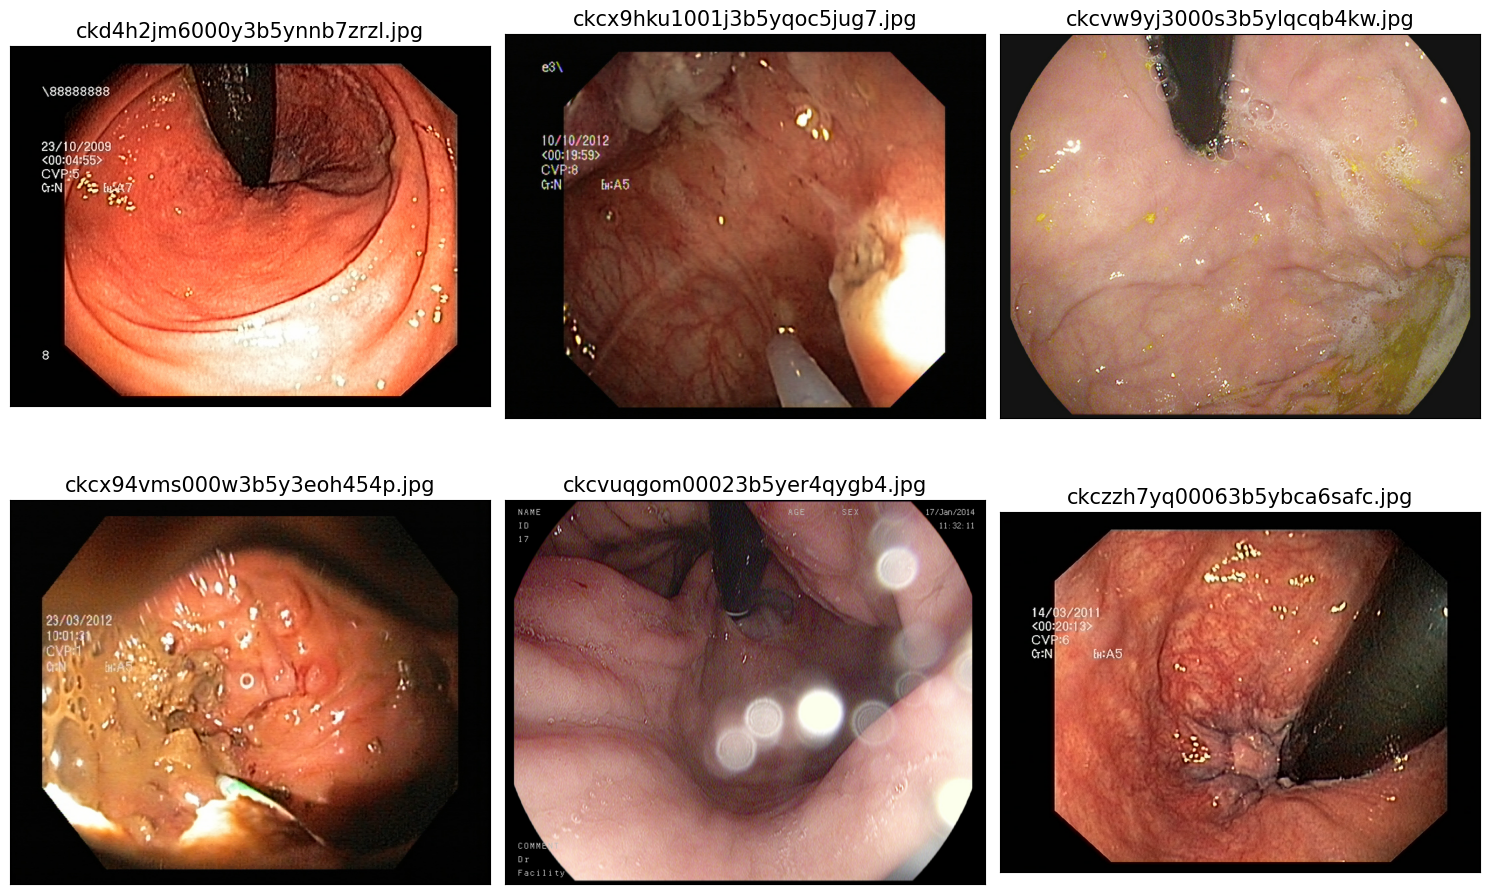

In [ ]:
images_list = []
for dirpath, dirnames, filenames in os.walk('/content/data/kvasir-instrument/images'):
  for filename in filenames:
    if filename.endswith('.jpg'):
      images_list.append(os.path.join(dirpath, filename))

print(images_list[:5])

n_rows = 2
n_cols = 3
total_images = n_rows * n_cols

fig = plt.figure(figsize=(15, 10))

for i, file in enumerate(images_list[:total_images]):
  img = Image.open(file)
  print('Image shape:', np.array(img).shape)

  ax = fig.add_subplot(n_rows, n_cols, i+1)
  ax.set_xticks([])
  ax.set_yticks([])
  ax.imshow(img)
  ax.set_title(os.path.basename(file), size=15)

plt.tight_layout()
plt.show()

['/content/data/kvasir-instrument/masks/ckcx9ogfz001v3b5yrrw3tifa.png', '/content/data/kvasir-instrument/masks/ckd0acv5500053b5yadn102bm.png', '/content/data/kvasir-instrument/masks/ckcxco0hp000b3b5y9iq60pv9.png', '/content/data/kvasir-instrument/masks/ckcxb70bd000z3b5yqpng1jrs.png', '/content/data/kvasir-instrument/masks/ckcu9ksoq00093b5ylw5wwfr2.png']
Original Image shape: (1024, 1280, 3)
Single-channel mask shape: (1024, 1280)
0.0 1.0
Original Image shape: (576, 720, 3)
Single-channel mask shape: (576, 720)
0.0 1.0
Original Image shape: (576, 768, 3)
Single-channel mask shape: (576, 768)
0.0 1.0
Original Image shape: (1024, 1280, 3)
Single-channel mask shape: (1024, 1280)
0.0 1.0
Original Image shape: (1071, 1349, 3)
Single-channel mask shape: (1071, 1349)
0.0 1.0
Original Image shape: (576, 768, 3)
Single-channel mask shape: (576, 768)
0.0 1.0


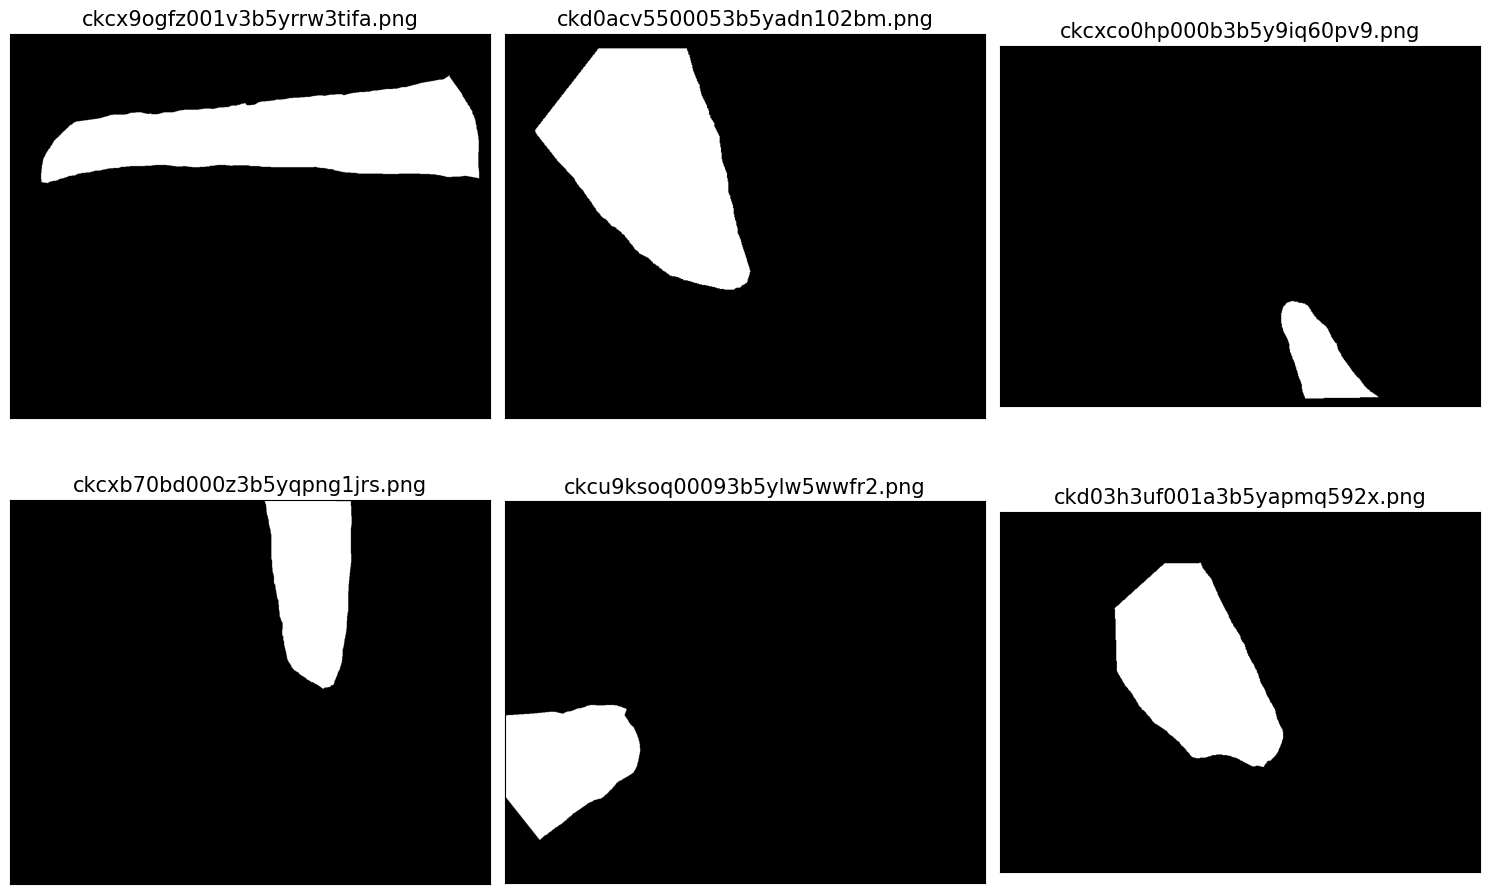

In [ ]:
masks_list = []
for dirpath, dirnames, filenames in os.walk('/content/data/kvasir-instrument/masks'):
  for filename in filenames:
    if filename.endswith('.png'):
      masks_list.append(os.path.join(dirpath, filename))

print(masks_list[:5])

n_rows = 2
n_cols = 3
total_masks = n_rows * n_cols

fig = plt.figure(figsize=(15, 10))

for i, file in enumerate(masks_list[:total_masks]):
    # Load the masks
    mask = Image.open(file)
    print('Original Image shape:', np.array(mask).shape)
    mask = np.array(mask)

    # Convert 3-channel mask to 1-channel mask
    single_channel_mask = mask[:, :, 0]
    print('Single-channel mask shape:', single_channel_mask.shape)

    # check the mask pixel, ensure ground truth masks pixel within [0, 1]
    if single_channel_mask.max() > 1:
      single_channel_mask = single_channel_mask / 255.0
      print(single_channel_mask.min(), single_channel_mask.max())

    ax = fig.add_subplot(n_rows, n_cols, i+1)
    ax.set_xticks([])
    ax.set_yticks([])
    #ax.imshow(mask)
    ax.imshow(single_channel_mask, cmap='gray')  # Use a grayscale colormap for single-channel images
    ax.set_title(os.path.basename(file), size=15)

plt.tight_layout()
plt.show()

**Neural Network Models**

In [ ]:
from matplotlib.rcsetup import validate_color_or_auto
# Get model
def get_model(model_name, in_channels, out_channels, activation_fn=None):
  if model_name == 'unet':
    return UNet(in_channels, out_channels, activation_fn)
  elif model_name == 'unet++':
    return UNetPlusPlus(in_channels, out_channels)
  elif model_name == 'fpn':
    return FPN(encoder_name='resnet34', in_channels=in_channels, out_channels=out_channels, activation_fn=activation_fn())
  else:
    raise ValueError(f"Model {model_name} not recognized")

# UNet
class UNet(nn.Module):
  def __init__(self, in_channels, out_channels, activation_fn):
    super(UNet, self).__init__()
    self.device = device

    # Pass the activation as a parameter
    self.activation_fn = activation_fn

    # Define the encoder
    self.enc1 = self.conv_block(in_channels, 64)
    self.enc2 = self.conv_block(64, 128)
    self.enc3 = self.conv_block(128, 256)
    self.enc4 = self.conv_block(256, 512)

    # Define the center
    self.center = self.conv_block(512, 1024)

    # Define the decoder
    self.dec4 = self.conv_block(1024 + 512, 512)
    self.dec3 = self.conv_block(512 + 256, 256)
    self.dec2 = self.conv_block(256 + 128, 128)
    self.dec1 = nn.Conv2d(128 + 64, out_channels, kernel_size=1)

    self.pool = nn.MaxPool2d(2, 2)

  def forward(self, x):
    enc1 = self.enc1(x)
    enc2 = self.enc2(self.pool(enc1))
    enc3 = self.enc3(self.pool(enc2))
    enc4 = self.enc4(self.pool(enc3))

    center = self.center(self.pool(enc4))

    dec4 = self.dec4(torch.cat([F.interpolate(center, scale_factor=2, mode='bilinear'), enc4], 1))
    dec3 = self.dec3(torch.cat([F.interpolate(dec4, scale_factor=2, mode='bilinear'), enc3], 1))
    dec2 = self.dec2(torch.cat([F.interpolate(dec3, scale_factor=2, mode='bilinear'), enc2], 1))
    dec1 = self.dec1(torch.cat([F.interpolate(dec2, scale_factor=2, mode='bilinear'), enc1], 1))

    return dec1

  def conv_block(self, in_channels, out_channels):
    return nn.Sequential(
    nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
    self.activation_fn(),
    nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
    self.activation_fn(),
    )

# UNet++ Decoder
class UNetPlusPlusDecoder(nn.Module):
    def __init__(self, encoder_channels, decoder_channels, activation=nn.ReLU()):
        super(UNetPlusPlusDecoder, self).__init__()
        self.activation = activation

        self.conv0_0 = self.conv_block(encoder_channels[0], decoder_channels[0])
        self.conv1_0 = self.conv_block(encoder_channels[1], decoder_channels[1])
        self.conv1_1 = self.conv_block(decoder_channels[0] + decoder_channels[1], decoder_channels[1])
        self.conv2_0 = self.conv_block(encoder_channels[2], decoder_channels[2])
        self.conv2_1 = self.conv_block(decoder_channels[1] + decoder_channels[2], decoder_channels[2])
        self.conv2_2 = self.conv_block(decoder_channels[0] + decoder_channels[1] + decoder_channels[2], decoder_channels[2])

    def conv_block(self, in_channels, out_channels):
        """Returns a block of Conv2D -> BatchNorm2d -> Activation"""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            self.activation
        )

    def upsample_to_size(self, x, target_size):
        return F.interpolate(x, size=target_size, mode='bilinear', align_corners=True)

    def forward(self, x1, x2, x3, x4):
        x0_0 = self.conv0_0(x4)
        x1_0 = self.conv1_0(self.upsample_to_size(x3, x2.shape[2:]))
        x1_1 = self.conv1_1(torch.cat([x1_0, self.upsample_to_size(x0_0, x1_0.shape[2:])], 1))
        x2_0 = self.conv2_0(self.upsample_to_size(x2, x1_0.shape[2:]))
        x2_1 = self.conv2_1(torch.cat([x2_0, self.upsample_to_size(x1_1, x2_0.shape[2:])], 1))
        x2_2 = self.conv2_2(torch.cat([x2_1, self.upsample_to_size(x1_1, x2_1.shape[2:]), self.upsample_to_size(x0_0, x2_1.shape[2:])], 1))
        return x2_2

# UNet++
class UNetPlusPlus(nn.Module):
    def __init__(self, in_channels, out_channels, activation=nn.ReLU()):
        super(UNetPlusPlus, self).__init__()
        self.encoder = torchvision.models.resnet34(pretrained=True)

        encoder_channels = [512, 256, 128, 64]
        decoder_channels = [256, 128, 64, 32]

        self.decoder = UNetPlusPlusDecoder(encoder_channels, decoder_channels, activation)
        self.segmentation_head = nn.Conv2d(decoder_channels[2], out_channels, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.encoder.conv1(x)
        x = self.encoder.bn1(x)
        x = self.encoder.relu(x)
        x = self.encoder.maxpool(x)

        x1 = self.encoder.layer1(x)
        x2 = self.encoder.layer2(x1)
        x3 = self.encoder.layer3(x2)
        x4 = self.encoder.layer4(x3)

        x = self.decoder(x1, x2, x3, x4)
        x = self.segmentation_head(x)

        # If the output size should match the input size, add this:
        x = F.interpolate(x, size=(576, 720), mode='bilinear', align_corners=True)

        return x


# Convolution block with 3x3 kernel size, Group Normalization, and ReLU activation
class Conv3x3GNReLU(nn.Module):
    def __init__(self, in_channels, out_channels, upsample=False):
        super().__init__()
        self.upsample = upsample
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, (3, 3), stride=1, padding=1, bias=False),
            nn.GroupNorm(32, out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        x = self.block(x)
        if self.upsample:
            x = F.interpolate(x, scale_factor=2, mode="bilinear", align_corners=True)
        return x

# Feature Pyramid Network block
class FPNBlock(nn.Module):
    def __init__(self, pyramid_channels, skip_channels):
        super().__init__()
        self.skip_conv = nn.Conv2d(skip_channels, pyramid_channels, kernel_size=1, bias=False)

    def forward(self, x, skip=None):
        x = F.interpolate(x, scale_factor=2, mode="nearest")
        if skip is not None:
            skip = self.skip_conv(skip)
            skip = F.interpolate(skip, size=x.shape[2:], mode='bilinear', align_corners=True)
            x = x + skip
        return x

# Segmentation block with a series of convolutions and upsampling
class SegmentationBlock(nn.Module):
    def __init__(self, in_channels, out_channels, n_upsamples=0):
        super().__init__()
        blocks = [Conv3x3GNReLU(in_channels, out_channels, upsample=bool(n_upsamples))]

        if n_upsamples > 1:
            for _ in range(1, n_upsamples):
                blocks.append(Conv3x3GNReLU(out_channels, out_channels, upsample=True))

        self.block = nn.Sequential(*blocks)

    def forward(self, x):
        return self.block(x)

# Merge block to combine features using addition or concatenation
class MergeBlock(nn.Module):
    def __init__(self, policy='add'):
        super().__init__()
        self.policy = policy

    def forward(self, x):
        if self.policy == 'add':
            return sum(x)
        elif self.policy == 'cat':
            return torch.cat(x, dim=1)
        else:
            raise ValueError("`merge_policy` must be one of: ['add', 'cat']")

# FPN Decoder combining the feature pyramid with skip connections
class FPNDecoder(nn.Module):
    def __init__(self, encoder_channels, pyramid_channels=256, segmentation_channels=128, merge_policy='add'):
        super().__init__()

        self.p5 = nn.Conv2d(encoder_channels[0], pyramid_channels, kernel_size=1)
        self.p4 = FPNBlock(pyramid_channels, encoder_channels[1])
        self.p3 = FPNBlock(pyramid_channels, encoder_channels[2])
        self.p2 = FPNBlock(pyramid_channels, encoder_channels[3])

        self.seg_blocks = nn.ModuleList([
            SegmentationBlock(pyramid_channels, segmentation_channels, n_upsamples=n_upsamples)
            for n_upsamples in [3, 2, 1, 0]
        ])

        self.merge = MergeBlock(merge_policy)

    def forward(self, *features):
        features = features[::-1]  # Reverse the features to match the FPN order

        p5 = self.p5(features[0])
        p4 = self.p4(p5, features[1])
        p3 = self.p3(p4, features[2])
        p2 = self.p2(p3, features[3])

        feature_pyramid = [seg_block(p) for seg_block, p in zip(self.seg_blocks, [p5, p4, p3, p2])]
        x = self.merge(feature_pyramid)

        return x

# FPN main class
class FPN(nn.Module):
    def __init__(self, encoder_name='resnet34', in_channels=3, decoder_pyramid_channels=256, segmentation_channels=128, out_channels=1, activation_fn=nn.ReLU(), pretrained=True):
        super(FPN, self).__init__()

        if encoder_name not in ['resnet34', 'resnet50']:
            raise ValueError(f"Encoder {encoder_name} is not supported")

        if encoder_name == 'resnet34':
            self.encoder = torchvision.models.resnet34(pretrained=pretrained)
            encoder_channels = [512, 256, 128, 64]# For ResNet34
            decoder_channels = [256, 128, 64, 32]
        elif encoder_name == 'resnet50':
            self.encoder = torchvision.models.resnet50(pretrained=pretrained)
            encoder_channels = [2048, 1024, 512, 256]  # For ResNet50

        if in_channels != 3:
            self.encoder.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)

        self.decoder = FPNDecoder(encoder_channels, pyramid_channels=decoder_pyramid_channels, segmentation_channels=segmentation_channels, merge_policy='add')
        self.segmentation_head = nn.Conv2d(segmentation_channels, out_channels, kernel_size=1)

    def forward(self, x):
        # Extract features using the encoder's predefined layers
        features = [x]
        for layer_name in ['conv1', 'bn1', 'relu', 'maxpool', 'layer1', 'layer2', 'layer3', 'layer4']:
            layer = getattr(self.encoder, layer_name)
            features[-1] = layer(features[-1])
            if layer_name.startswith('layer'):
                features.append(features[-1])

        # The FPN decoder uses the last 4 features (skip connections)
        features = features[-5:-1]

        # Pass the features through the FPN decoder
        x = self.decoder(*features)

        # Pass the result through the segmentation head
        x = self.segmentation_head(x)

        # If the output size should match the input size, add this:
        x = F.interpolate(x, size=(576, 720), mode='bilinear', align_corners=True)

        return x

class EarlyStopping:
  def __init__(self, patience=7, verbose=False, activation_name=''):
    self.patience = patience
    self.verbose = verbose
    #self.delta = delta
    self.counter = 0
    self.best_iou = float('-inf') # Initialize with negative infinity for maximizing
    self.early_stop = False
    self.path = f"best_checkpoint_{activation_name}.pt"

  def __call__(self, test_loss, test_accuracy, test_dsc_val, iou_score, model):
    #score_improvement = iou_score - self.best_iou
    if iou_score > self.best_iou:
      self.best_iou = iou_score
      self.save_checkpoint(test_loss, test_accuracy, test_dsc_val, iou_score, model)
      self.counter = 0
    else:
      self.counter += 1
      print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
      if self.counter >= self.patience:
        self.early_stop = True

  def save_checkpoint(self, test_loss, test_accuracy, test_dsc_val, iou_score, model):
    '''Saves model when test IoU increases.'''
    if self.verbose:
      print(f'Test IoU increased {self.best_iou: .6f} --> {iou_score: .6f}. Saving model......')
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'loss': test_loss,
        'accuracy': test_accuracy,
        'DSC': test_dsc_val,
        'IoU_score': iou_score,
        }
    torch.save(checkpoint, self.path)

# Functions for training and testing
def train(dataloader, model, loss_fn, optimizer, device):
  model.train()  # Set the model to training mode
  running_loss = 0.0
  running_corrects = 0.0
  running_dice = 0.0
  running_iou = 0.0
  total_pixels = 0.0
  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)
    y = y.squeeze(1) # Squeeze y to one dimension

    # Compute prediction, accuracy and loss
    pred = model(X)
    loss = loss_fn(pred, y.float()) # Do not extract the loss value before calculating the loss and doing backpropagation.

    # Backpropagation
    optimizer.zero_grad()
    loss.backward() # Backpropagation can be done here because loss is still a tensor
    optimizer.step()

    pred_binary = torch.sigmoid(pred) > 0.5
    corrects = (pred_binary.float() == y).float().sum().item()
    running_corrects += corrects
    total_pixels += y.numel()

    # Calculate batch Dice and Iou
    batch_dice = dice_coefficient(pred_binary, y).mean().item()
    batch_iou = iou_score(pred_binary, y).mean().item()

    # Update the running metrics
    running_loss += loss.item()
    running_dice += batch_dice
    running_iou += batch_iou

  # Compute average metrics for the epoch
  train_loss = running_loss / len(dataloader)
  train_accuracy = running_corrects / total_pixels
  train_dice = running_dice / len(dataloader)
  train_iou = running_iou / len(dataloader)

  #print(f"Epoch {epoch+1}/{num_epochs} => Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Train Dice: {train_dice:.4f}, Train IoU: {train_iou:.4f}")
  return train_loss, train_accuracy, train_dice, train_iou

def test(dataloader, model, loss_fn, device):
  model.eval()
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  test_loss, correct = 0, 0
  running_corrects = 0.0
  total_pixels = 0.0
  running_dice = 0.0
  running_iou = 0.0
  with torch.no_grad():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)
      y = y.squeeze(1)

      pred = model(X)
      loss = loss_fn(pred, y.float())
      test_loss += loss_fn(pred, y.float()).item()  # Use .item() directly to obtain and accumulate the loss value for subsequent processing.
      pred_binary = torch.sigmoid(pred) > 0.5

      # Verify shape, ensure y and pred_binary are in the same shape
      if y.shape != pred_binary.shape:
          print(f"Warning: Shape mismatch! y: {y.shape}, pred_binary: {pred_binary.shape}")
          # Output the class count if the shape is mismatched
          class_counts = [(y == i).sum().item() for i in [0, 1]]
          print(f"Class counts - 0: {class_counts[0]}, 1: {class_counts[1]}")

      corrects = (pred_binary.float() == y).float().sum().item()
      running_corrects += corrects
      total_pixels += y.numel()
      running_dice += dice_coefficient(pred_binary, y).mean().item()
      running_iou += iou_score(pred_binary, y).mean().item()

  test_loss /= num_batches
  correct /= size
  test_accuracy = running_corrects / total_pixels
  test_dice = running_dice / len(dataloader)
  test_iou = running_iou / len(dataloader)
  return test_loss, test_accuracy, test_dice, test_iou

#Calculate Dice Coefficient
def dice_coefficient(pred, target):
  smooth = 1
  pred_flat = pred.view(-1)
  target_flat = target.view(-1)
  intersection = (pred_flat * target_flat).sum()
  return (2. * intersection + smooth) / (pred_flat.sum() + target_flat.sum() + smooth)

#Calculate Dice Loss
def dice_loss(pred, target):
  return 1 - dice_coefficient(pred, target)

#Calculate Mean Intersection over Union (IoU)
def iou_score(pred, target):
  # Convert boolean or float tensors to byte tensors
  if pred.dtype == torch.float32:
    pred = pred.bool()
  if target.dtype == torch.float32:
      target = target.bool()

  intersection = (pred & target).float().sum((1,2))
  union = (pred | target).sum((1,2))
  iou = (intersection.float() + 1) / (union.float() + 1) # Convert back to float for division
  return iou.mean()

# Ref.: https://github.com/qubvel/segmentation_models.pytorch/blob/master/examples/binary_segmentation_intro.ipynb
def visualize_samples(images, ground_truths, predictions, epoch, device):
  """Visualize a batch of samples with their ground truth and prediction."""
  batch_size = images.size(0)
  fig, axs = plt.subplots(batch_size, 3, figsize=(15, 15))
  for i in range(batch_size):
    axs[i, 0].imshow(images[i].detach().to("cpu").permute(1, 2, 0).numpy())
    axs[i, 0].set_title('Image')
    axs[i, 1].imshow(ground_truths[i][0].detach().to("cpu").numpy().squeeze(), cmap='gray')
    axs[i, 1].set_title('Ground Truth')
    axs[i, 2].imshow(predictions[i][0].detach().to("cpu").numpy().squeeze(), cmap='gray')
    axs[i, 2].set_title('Prediction')

  #plt.suptitle(f'Epoch {epoch+1}')
  plt.show()

**UNet without Augmentation │ RELU │ Adam**




Training model: unet
Test IoU increased  0.667842 -->  0.667842. Saving model......
Epoch 1 => Training Loss: 0.3244 - Training Accuracy: 89.22% - Test Loss: 0.4053 - Test Accuracy: 90.67% - Training DSC: 0.0020 - Test DSC: 0.0000 - Training IoU: 0.6581 - Test IoU: 0.6678
EarlyStopping counter: 1 out of 5
Epoch 2 => Training Loss: 0.1828 - Training Accuracy: 90.46% - Test Loss: 0.4055 - Test Accuracy: 83.11% - Training DSC: 0.1096 - Test DSC: 0.3100 - Training IoU: 0.6796 - Test IoU: 0.4624
EarlyStopping counter: 2 out of 5
Epoch 3 => Training Loss: 0.1816 - Training Accuracy: 91.87% - Test Loss: 0.3834 - Test Accuracy: 86.39% - Training DSC: 0.3314 - Test DSC: 0.2789 - Training IoU: 0.7068 - Test IoU: 0.5075
EarlyStopping counter: 3 out of 5
Epoch 4 => Training Loss: 0.1514 - Training Accuracy: 94.02% - Test Loss: 0.4672 - Test Accuracy: 80.86% - Training DSC: 0.6551 - Test DSC: 0.2825 - Training IoU: 0.7527 - Test IoU: 0.4726
EarlyStopping counter: 4 out of 5
Epoch 5 => Training Los

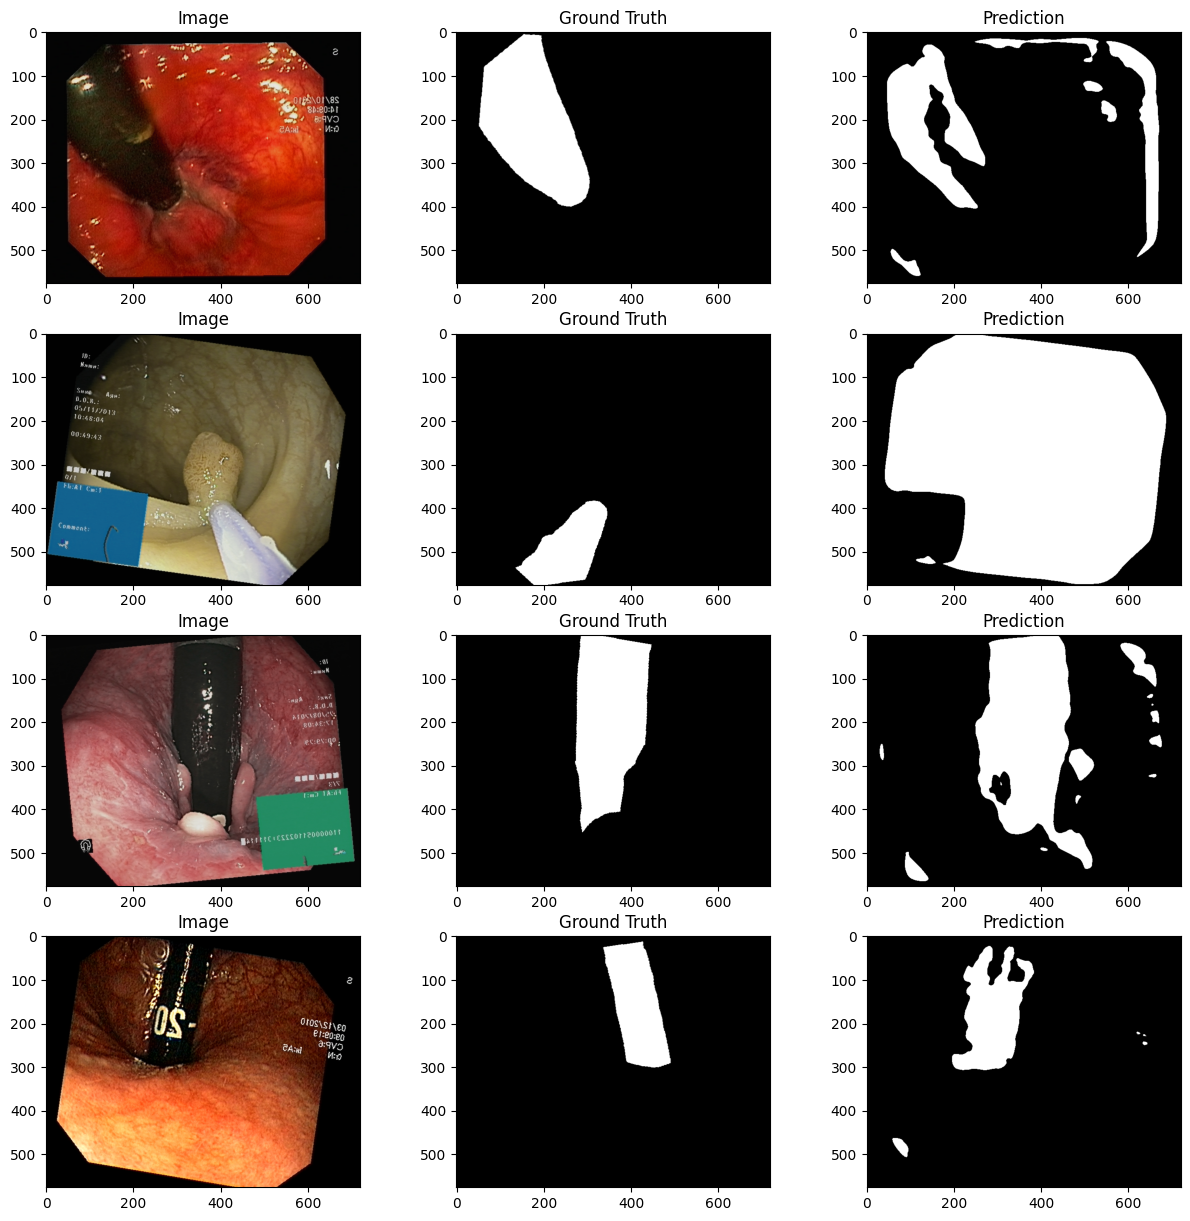

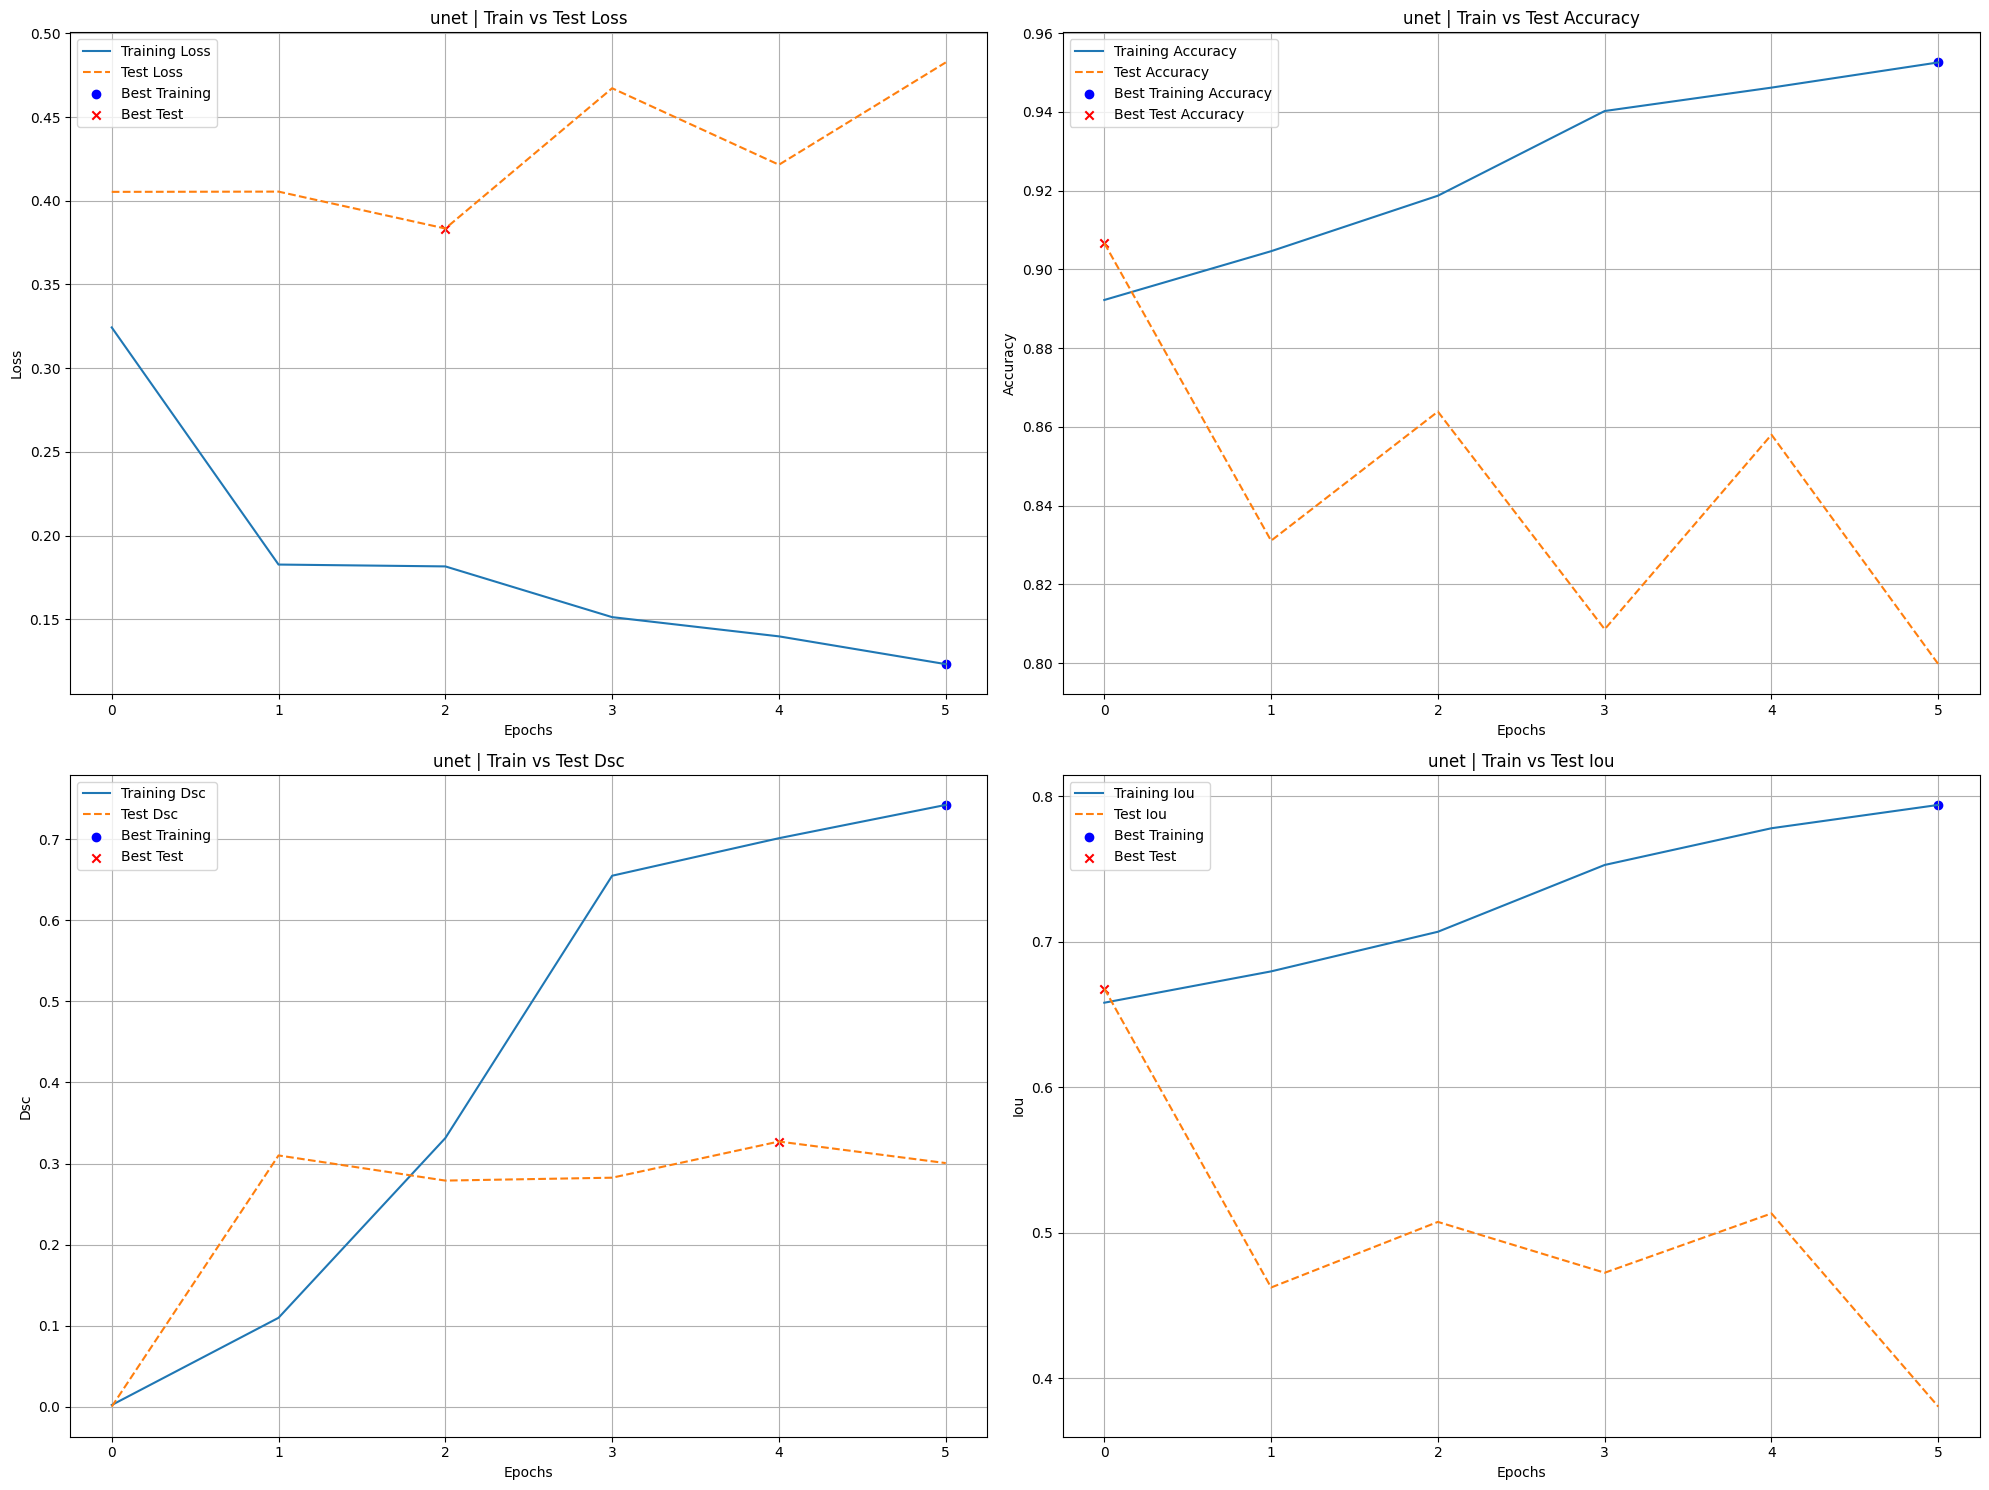


Best Results:
------------------------------------------------------------------------------------------
Model           | Best Loss  | Best Accuracy (%) | Best DSC   | Best IoU  
------------------------------------------------------------------------------------------
unet            | 0.4826     | 79.97          % | 0.3006     | 0.3805    
------------------------------------------------------------------------------------------


In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR

def train_and_evaluate_models(train_loader, test_loader, device='cuda'):
    # Hyperparameters
    input_size = (576, 720)
    out_channels = 1
    batch_size = 4
    visualized = False


    # Define models with ReLU activation
    models = {
        'unet': get_model('unet', 3, out_channels, activation_fn=nn.ReLU)
    }


    # Ref.: https://machinelearningmastery.com/activation-functions-in-pytorch/
    # Initialize results storage
    results = {}
    best_results = {}
    for name, model in models.items():
        print(f"\nTraining model: {name}")
        model.to(device)

        criterion = torch.nn.BCEWithLogitsLoss()
        # use Learning-rate scheduler
        optimizer = optim.Adam(model.parameters(), lr=1e-4) # can reduce the lr to 1e-4, 1e-8 ...
        scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
        early_stopping = EarlyStopping(patience=5, verbose=True, activation_name=name)

        # Initilize the train and test storage list
        train_loss_history = []
        train_accuracy_history = []
        test_accuracy_history = []
        train_dsc_history = []
        test_dsc_history = []
        train_iou_history = []
        test_iou_history = []
        test_loss_history = []

        # Variables to save the best images, ground truths and predictions
        best_images, best_ground_truths = next(iter(test_loader))
        best_images, best_ground_truths = best_images.to(device), best_ground_truths.to(device)
        best_predictions = None

        # Initialize best metrics
        best_loss = float('inf')
        best_accuracy = 0.0
        best_dsc = 0.0
        best_iou = 0.0
        epoch = 0

        while not early_stopping.early_stop:
            # use different learning rates to train the model
            train_loss, train_accuracy, train_dsc, train_iou = train(train_loader, model, criterion, optimizer, device)
            test_loss, test_accuracy, test_dsc, test_iou = test(test_loader, model, criterion, device)

            # Append to the lists
            train_loss_history.append(train_loss)
            test_loss_history.append(test_loss)
            train_accuracy_history.append(train_accuracy)
            test_accuracy_history.append(test_accuracy)
            train_dsc_history.append(train_dsc)
            test_dsc_history.append(test_dsc)
            train_iou_history.append(train_iou)
            test_iou_history.append(test_iou)

            early_stopping(test_loss, test_accuracy, test_dsc, test_iou, model)
            if early_stopping.early_stop:
                print('Early stopping')
                break
            scheduler.step()
            epoch += 1

            print(f"Epoch {epoch} => "
                  f"Training Loss: {train_loss:.4f} - "
                  f"Training Accuracy: {train_accuracy*100:.2f}% - "
                  f"Test Loss: {test_loss:.4f} - "
                  f"Test Accuracy: {test_accuracy*100:.2f}% - "
                  f"Training DSC: {train_dsc:.4f} - "
                  f"Test DSC: {test_dsc:.4f} - "
                  f"Training IoU: {train_iou:.4f} - "
                  f"Test IoU: {test_iou:.4f}")

        # Save the best model based on IoU
        if test_iou > best_iou:
            best_loss = test_loss
            best_accuracy = test_accuracy
            best_dsc = test_dsc
            best_iou = test_iou
            torch.save(model.state_dict(), f'best_checkpoint_{name}.pt')

        results[name] = {
            'train_loss_history': train_loss_history,
            'test_loss_history': test_loss_history,
            'train_accuracy_history': train_accuracy_history,
            'test_accuracy_history': test_accuracy_history,
            'train_dsc_history': train_dsc_history,
            'test_dsc_history': test_dsc_history,
            'train_iou_history': train_iou_history,
            'test_iou_history': test_iou_history
        }

        best_results[name] = {
            'Best Loss': best_loss,
            'Best Accuracy': best_accuracy,
            'Best DSC': best_dsc,
            'Best IoU': best_iou
        }

        # Save the batch images, ground truths, and predictions
        # Ref.: https://github.com/qubvel/segmentation_models.pytorch/blob/master/examples/binary_segmentation_intro.ipynb
        with torch.no_grad():
          for i, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            predictions = torch.sigmoid(outputs) > 0.5

            # Save the first batch of images, ground truth, and predictions
            if i == 0:
              best_images = inputs
              best_ground_truths = targets
              best_predictions = predictions
            break

    # Display images, ground truth, and predictions for the best checkpoint of the current activation
    if best_predictions is not None:
      visualize_samples(best_images, best_ground_truths, best_predictions, epoch, device)
    else:
      print(f'No best predictions for activation: {name}.')

    # Visualization for each model
    for name, data in results.items():
        plt.figure(figsize=(20, 15))
        metrics = ['loss', 'accuracy', 'dsc', 'iou']
        for i, metric in enumerate(metrics):
            plt.subplot(2, 2, i+1)
            plt.subplot(2, 2, i+1)
            plt.plot(data[f'train_{metric}_history'], label=f'Training {metric.capitalize()}')
            plt.plot(data[f'test_{metric}_history'], '--', label=f'Test {metric.capitalize()}')

            if metric in ['loss', 'dsc', 'iou']:
                best_train_idx = np.argmin(data[f'train_{metric}_history']) if metric == 'loss' else np.argmax(data[f'train_{metric}_history'])
                best_test_idx = np.argmin(data[f'test_{metric}_history']) if metric == 'loss' else np.argmax(data[f'test_{metric}_history'])
                plt.scatter(best_train_idx, data[f'train_{metric}_history'][best_train_idx], color='blue', marker='o', label='Best Training')
                plt.scatter(best_test_idx, data[f'test_{metric}_history'][best_test_idx], color='red', marker='x', label='Best Test')
            else:
                best_train_acc_idx = np.argmax(data['train_accuracy_history'])
                best_test_acc_idx = np.argmax(data['test_accuracy_history'])
                plt.scatter(best_train_acc_idx, data['train_accuracy_history'][best_train_acc_idx], color='blue', marker='o', label='Best Training Accuracy')
                plt.scatter(best_test_acc_idx, data['test_accuracy_history'][best_test_acc_idx], color='red', marker='x', label='Best Test Accuracy')

            plt.xlabel('Epochs')
            plt.ylabel(metric.capitalize())
            plt.title(f'{name} | Train vs Test {metric.capitalize()}')
            plt.legend()
            plt.grid()

        plt.tight_layout()
        plt.show()

    # Print the best results in a table format for each model
    print('\nBest Results:')
    print('-' * 90)
    # Add headers here with "Model" instead of "Activation"
    print("{:<15} | {:<10} | {:<15} | {:<10} | {:<10}".format('Model', 'Best Loss', 'Best Accuracy (%)', 'Best DSC', 'Best IoU'))
    print('-' * 90)
    for key, value in best_results.items():
      print("{:<15} | {:<10.4f} | {:<15.2f}% | {:<10.4f} | {:<10.4f}".format(key, value["Best Loss"], value["Best Accuracy"]*100, value["Best DSC"], value["Best IoU"]))
    print("-" * 90)


# Usage
train_and_evaluate_models(train_loader, test_loader)

**UNet with Augmentation │ RELU │ Adam**


Training model: unet
Test IoU increased  0.666642 -->  0.666642. Saving model......
Epoch 1 => Training Loss: 0.3661 - Training Accuracy: 89.42% - Test Loss: 0.2917 - Test Accuracy: 90.68% - Training DSC: 0.0017 - Test DSC: 0.0000 - Training IoU: 0.6568 - Test IoU: 0.6666
Test IoU increased  0.670588 -->  0.670588. Saving model......
Epoch 2 => Training Loss: 0.3003 - Training Accuracy: 89.91% - Test Loss: 0.2694 - Test Accuracy: 90.68% - Training DSC: 0.0000 - Test DSC: 0.0000 - Training IoU: 0.6675 - Test IoU: 0.6706
EarlyStopping counter: 1 out of 5
Epoch 3 => Training Loss: 0.2898 - Training Accuracy: 89.91% - Test Loss: 0.2552 - Test Accuracy: 90.66% - Training DSC: 0.0000 - Test DSC: 0.0000 - Training IoU: 0.6679 - Test IoU: 0.6690
EarlyStopping counter: 2 out of 5
Epoch 4 => Training Loss: 0.2797 - Training Accuracy: 89.90% - Test Loss: 0.2726 - Test Accuracy: 90.67% - Training DSC: 0.0000 - Test DSC: 0.0000 - Training IoU: 0.6658 - Test IoU: 0.6685
EarlyStopping counter: 3 out

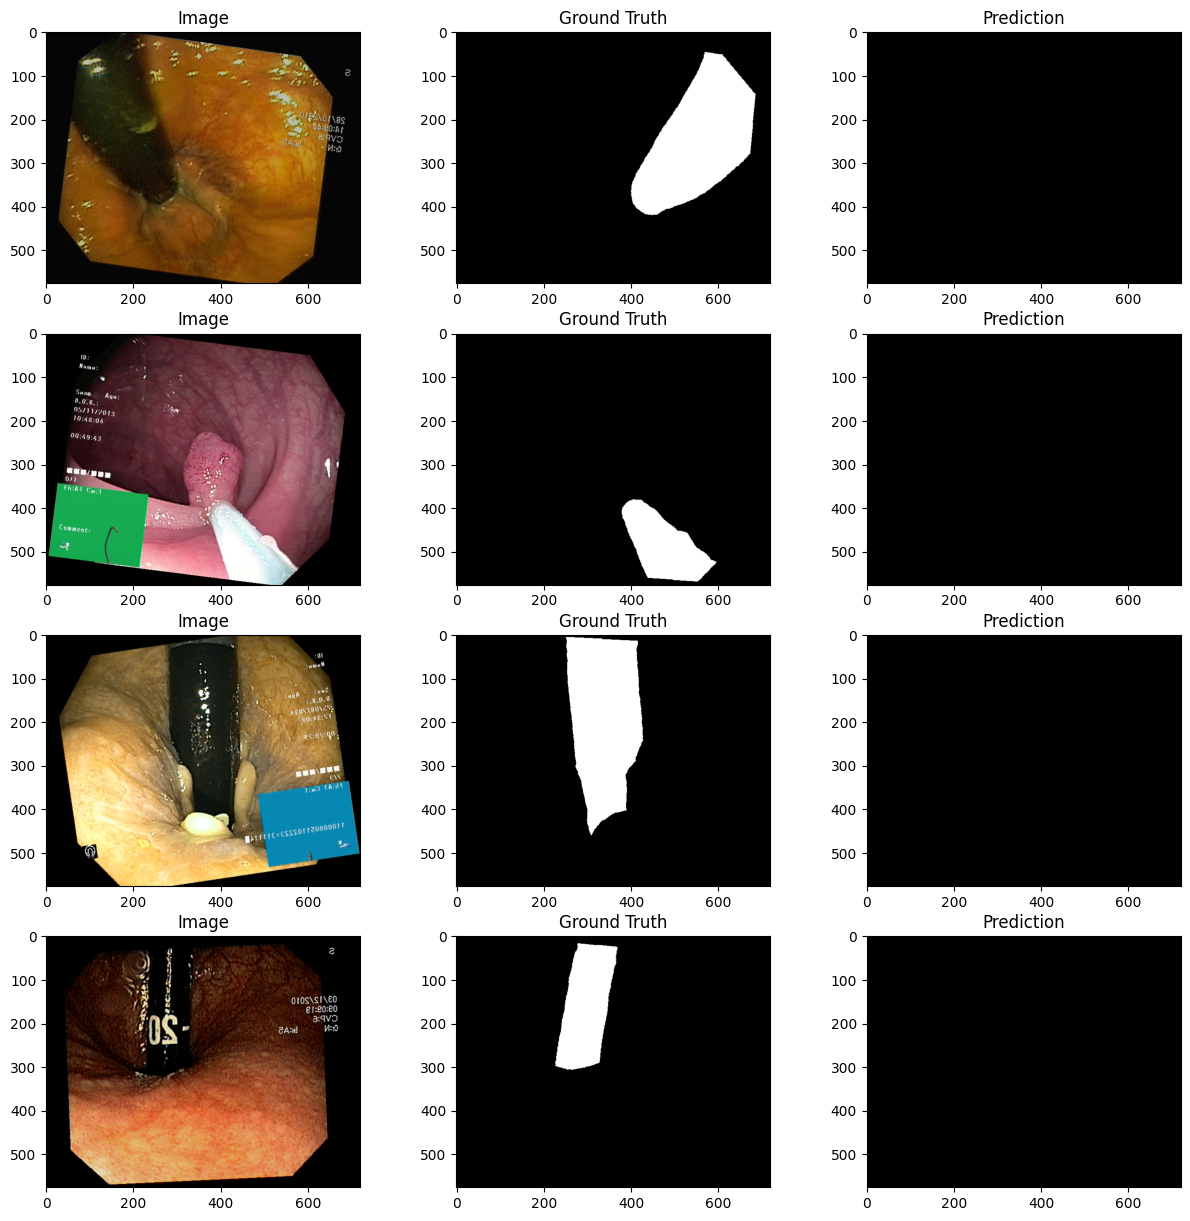

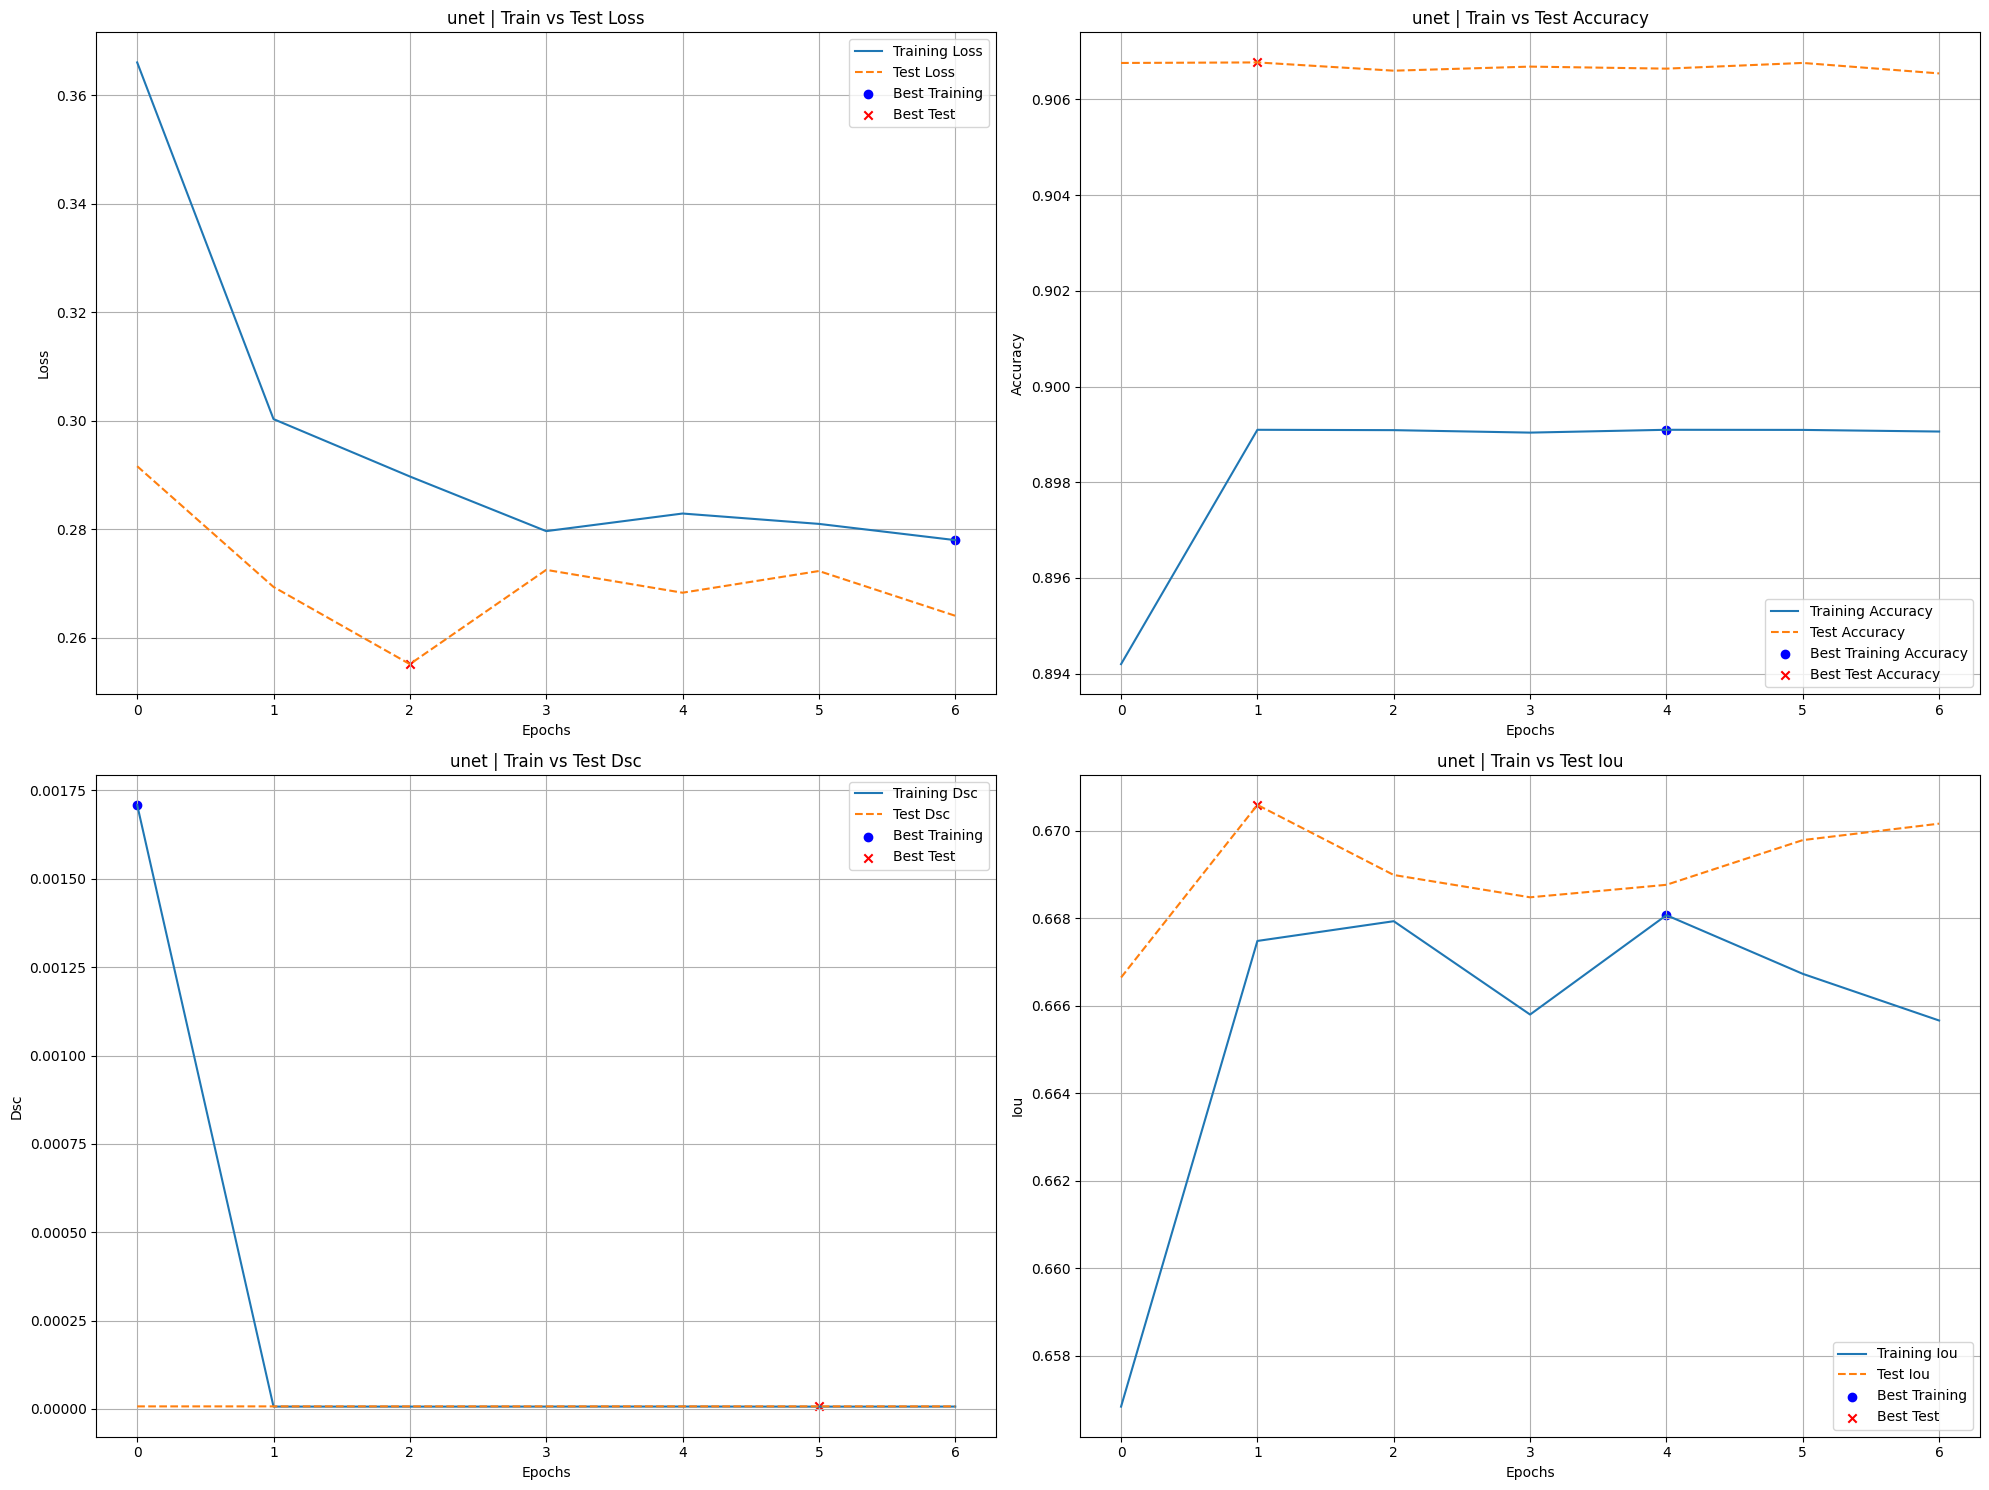


Best Results:
------------------------------------------------------------------------------------------
Model           | Best Loss  | Best Accuracy (%) | Best DSC   | Best IoU  
------------------------------------------------------------------------------------------
unet            | 0.2641     | 90.65          % | 0.0000     | 0.6702    
------------------------------------------------------------------------------------------


In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR

# Define the augmentation transforms
mask_augmented_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize((576, 720)),
    transforms.ToTensor(),
])

image_augmented_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.Resize((576, 720)),
    transforms.ToTensor(),
])

# Create the augmented data loaders
training_data_augmented = KvasirInstrument(root="data", train=True, download=False, transform=image_augmented_transform, target_transform=mask_augmented_transform)
train_loader_augmented = DataLoader(training_data_augmented, batch_size=4, shuffle=True)

test_data = KvasirInstrument(root="data", train=False, download=False, transform=image_augmented_transform, target_transform=mask_augmented_transform)
test_loader = DataLoader(test_data, batch_size=4, shuffle=False)

def train_and_evaluate_models(train_loader, test_loader, device='cuda'):
    # Hyperparameters
    input_size = (576, 720)
    out_channels = 1
    batch_size = 4
    visualized = False


    # Define models with ReLU activation
    models = {
        'unet': get_model('unet', 3, out_channels, activation_fn=nn.ReLU)
    }


    # Ref.: https://machinelearningmastery.com/activation-functions-in-pytorch/
    # Initialize results storage
    results = {}
    best_results = {}
    for name, model in models.items():
        print(f"\nTraining model: {name}")
        model.to(device)

        criterion = torch.nn.BCEWithLogitsLoss()
        # use Learning-rate scheduler
        optimizer = optim.Adam(model.parameters(), lr=1e-4) # can reduce the lr to 1e-4, 1e-8 ...
        scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
        early_stopping = EarlyStopping(patience=5, verbose=True, activation_name=name)

        # Initilize the train and test storage list
        train_loss_history = []
        train_accuracy_history = []
        test_accuracy_history = []
        train_dsc_history = []
        test_dsc_history = []
        train_iou_history = []
        test_iou_history = []
        test_loss_history = []

        # Variables to save the best images, ground truths and predictions
        best_images, best_ground_truths = next(iter(test_loader))
        best_images, best_ground_truths = best_images.to(device), best_ground_truths.to(device)
        best_predictions = None

        # Initialize best metrics
        best_loss = float('inf')
        best_accuracy = 0.0
        best_dsc = 0.0
        best_iou = 0.0
        epoch = 0

        while not early_stopping.early_stop:
            # use different learning rates to train the model
            train_loss, train_accuracy, train_dsc, train_iou = train(train_loader, model, criterion, optimizer, device)
            test_loss, test_accuracy, test_dsc, test_iou = test(test_loader, model, criterion, device)

            # Append to the lists
            train_loss_history.append(train_loss)
            test_loss_history.append(test_loss)
            train_accuracy_history.append(train_accuracy)
            test_accuracy_history.append(test_accuracy)
            train_dsc_history.append(train_dsc)
            test_dsc_history.append(test_dsc)
            train_iou_history.append(train_iou)
            test_iou_history.append(test_iou)

            early_stopping(test_loss, test_accuracy, test_dsc, test_iou, model)
            if early_stopping.early_stop:
                print('Early stopping')
                break
            scheduler.step()
            epoch += 1

            print(f"Epoch {epoch} => "
                  f"Training Loss: {train_loss:.4f} - "
                  f"Training Accuracy: {train_accuracy*100:.2f}% - "
                  f"Test Loss: {test_loss:.4f} - "
                  f"Test Accuracy: {test_accuracy*100:.2f}% - "
                  f"Training DSC: {train_dsc:.4f} - "
                  f"Test DSC: {test_dsc:.4f} - "
                  f"Training IoU: {train_iou:.4f} - "
                  f"Test IoU: {test_iou:.4f}")

        # Save the best model based on IoU
        if test_iou > best_iou:
            best_loss = test_loss
            best_accuracy = test_accuracy
            best_dsc = test_dsc
            best_iou = test_iou
            torch.save(model.state_dict(), f'best_checkpoint_{name}.pt')

        results[name] = {
            'train_loss_history': train_loss_history,
            'test_loss_history': test_loss_history,
            'train_accuracy_history': train_accuracy_history,
            'test_accuracy_history': test_accuracy_history,
            'train_dsc_history': train_dsc_history,
            'test_dsc_history': test_dsc_history,
            'train_iou_history': train_iou_history,
            'test_iou_history': test_iou_history
        }

        best_results[name] = {
            'Best Loss': best_loss,
            'Best Accuracy': best_accuracy,
            'Best DSC': best_dsc,
            'Best IoU': best_iou
        }

        # Save the batch images, ground truths, and predictions
        # Ref.: https://github.com/qubvel/segmentation_models.pytorch/blob/master/examples/binary_segmentation_intro.ipynb
        with torch.no_grad():
          for i, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            predictions = torch.sigmoid(outputs) > 0.5

            # Save the first batch of images, ground truth, and predictions
            if i == 0:
              best_images = inputs
              best_ground_truths = targets
              best_predictions = predictions
            break

    # Display images, ground truth, and predictions for the best checkpoint of the current activation
    if best_predictions is not None:
      visualize_samples(best_images, best_ground_truths, best_predictions, epoch, device)
    else:
      print(f'No best predictions for activation: {name}.')

    # Visualization for each model
    for name, data in results.items():
        plt.figure(figsize=(20, 15))
        metrics = ['loss', 'accuracy', 'dsc', 'iou']
        for i, metric in enumerate(metrics):
            plt.subplot(2, 2, i+1)
            plt.subplot(2, 2, i+1)
            plt.plot(data[f'train_{metric}_history'], label=f'Training {metric.capitalize()}')
            plt.plot(data[f'test_{metric}_history'], '--', label=f'Test {metric.capitalize()}')

            if metric in ['loss', 'dsc', 'iou']:
                best_train_idx = np.argmin(data[f'train_{metric}_history']) if metric == 'loss' else np.argmax(data[f'train_{metric}_history'])
                best_test_idx = np.argmin(data[f'test_{metric}_history']) if metric == 'loss' else np.argmax(data[f'test_{metric}_history'])
                plt.scatter(best_train_idx, data[f'train_{metric}_history'][best_train_idx], color='blue', marker='o', label='Best Training')
                plt.scatter(best_test_idx, data[f'test_{metric}_history'][best_test_idx], color='red', marker='x', label='Best Test')
            else:
                best_train_acc_idx = np.argmax(data['train_accuracy_history'])
                best_test_acc_idx = np.argmax(data['test_accuracy_history'])
                plt.scatter(best_train_acc_idx, data['train_accuracy_history'][best_train_acc_idx], color='blue', marker='o', label='Best Training Accuracy')
                plt.scatter(best_test_acc_idx, data['test_accuracy_history'][best_test_acc_idx], color='red', marker='x', label='Best Test Accuracy')

            plt.xlabel('Epochs')
            plt.ylabel(metric.capitalize())
            plt.title(f'{name} | Train vs Test {metric.capitalize()}')
            plt.legend()
            plt.grid()

        plt.tight_layout()
        plt.show()

    # Print the best results in a table format for each model
    print('\nBest Results:')
    print('-' * 90)
    # Add headers here with "Model" instead of "Activation"
    print("{:<15} | {:<10} | {:<15} | {:<10} | {:<10}".format('Model', 'Best Loss', 'Best Accuracy (%)', 'Best DSC', 'Best IoU'))
    print('-' * 90)
    for key, value in best_results.items():
      print("{:<15} | {:<10.4f} | {:<15.2f}% | {:<10.4f} | {:<10.4f}".format(key, value["Best Loss"], value["Best Accuracy"]*100, value["Best DSC"], value["Best IoU"]))
    print("-" * 90)

# Usage
train_and_evaluate_models(train_loader_augmented, test_loader)

**UNet++ without Augmentation │ RELU │ Adam**


Training model: unet++
Test IoU increased  0.633598 -->  0.633598. Saving model......
Epoch 1 => Training Loss: 0.2315 - Training Accuracy: 94.72% - Test Loss: 0.3024 - Test Accuracy: 90.02% - Training DSC: 0.8102 - Test DSC: 0.3737 - Training IoU: 0.7889 - Test IoU: 0.6336
EarlyStopping counter: 1 out of 5
Epoch 2 => Training Loss: 0.0782 - Training Accuracy: 98.44% - Test Loss: 0.3779 - Test Accuracy: 89.01% - Training DSC: 0.9195 - Test DSC: 0.4369 - Training IoU: 0.9168 - Test IoU: 0.6171
Test IoU increased  0.642396 -->  0.642396. Saving model......
Epoch 3 => Training Loss: 0.0456 - Training Accuracy: 98.95% - Test Loss: 0.3700 - Test Accuracy: 90.07% - Training DSC: 0.9437 - Test DSC: 0.4252 - Training IoU: 0.9372 - Test IoU: 0.6424
Test IoU increased  0.648281 -->  0.648281. Saving model......
Epoch 4 => Training Loss: 0.0322 - Training Accuracy: 99.20% - Test Loss: 0.4185 - Test Accuracy: 90.45% - Training DSC: 0.9589 - Test DSC: 0.4366 - Training IoU: 0.9494 - Test IoU: 0.64

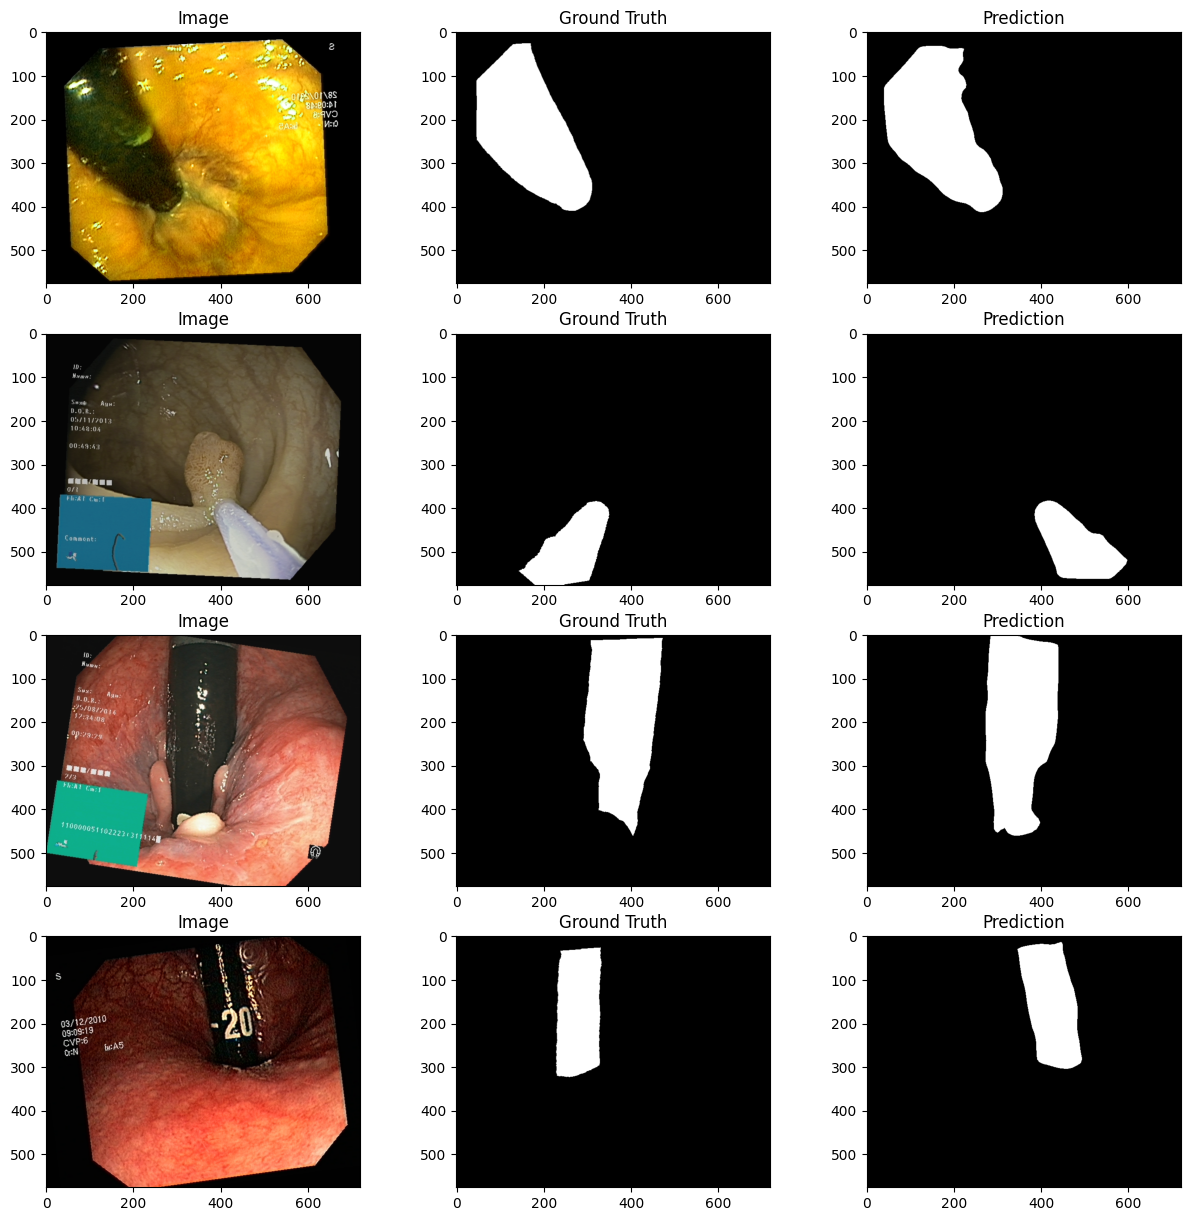

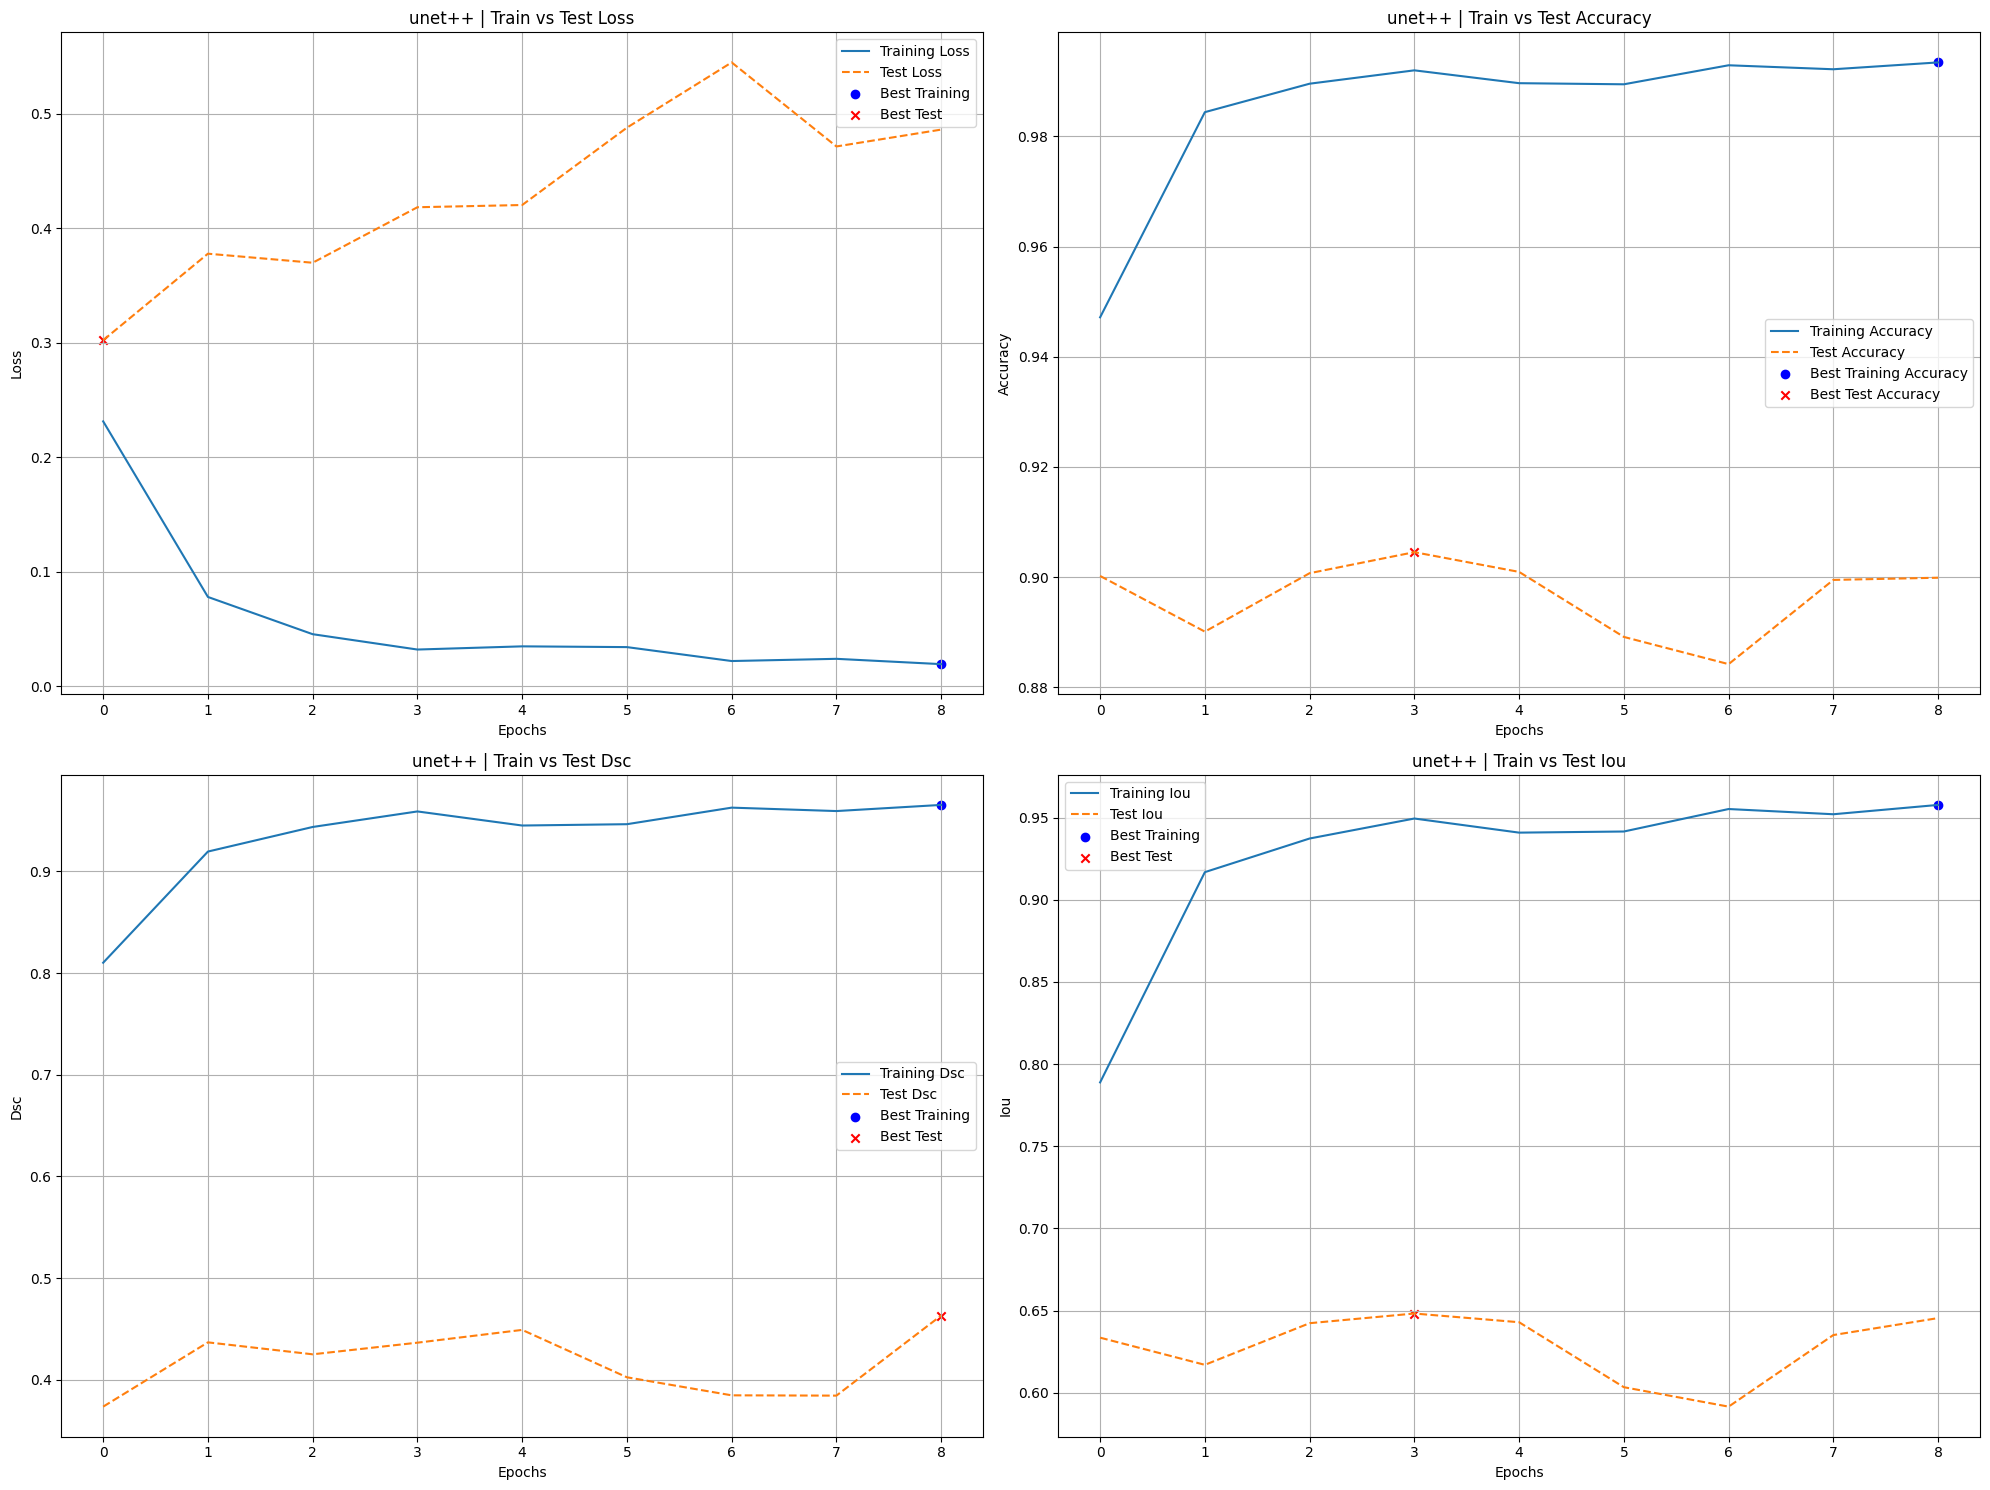


Best Results:
------------------------------------------------------------------------------------------
Model           | Best Loss  | Best Accuracy (%) | Best DSC   | Best IoU  
------------------------------------------------------------------------------------------
unet++          | 0.4863     | 89.99          % | 0.4633     | 0.6455    
------------------------------------------------------------------------------------------


In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR

def train_and_evaluate_models(train_loader, test_loader, device='cuda'):
    # Hyperparameters
    input_size = (576, 720)
    out_channels = 1
    batch_size = 4
    visualized = False


    # Define models with ReLU activation
    models = {
        'unet++': get_model('unet++', 3, out_channels, activation_fn=nn.ReLU),
    }


    # Ref.: https://machinelearningmastery.com/activation-functions-in-pytorch/
    # Initialize results storage
    results = {}
    best_results = {}
    for name, model in models.items():
        print(f"\nTraining model: {name}")
        model.to(device)

        criterion = torch.nn.BCEWithLogitsLoss()
        # use Learning-rate scheduler
        optimizer = optim.Adam(model.parameters(), lr=1e-4) # can reduce the lr to 1e-4, 1e-8 ...
        scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
        early_stopping = EarlyStopping(patience=5, verbose=True, activation_name=name)

        # Initilize the train and test storage list
        train_loss_history = []
        train_accuracy_history = []
        test_accuracy_history = []
        train_dsc_history = []
        test_dsc_history = []
        train_iou_history = []
        test_iou_history = []
        test_loss_history = []

        # Variables to save the best images, ground truths and predictions
        best_images, best_ground_truths = next(iter(test_loader))
        best_images, best_ground_truths = best_images.to(device), best_ground_truths.to(device)
        best_predictions = None

        # Initialize best metrics
        best_loss = float('inf')
        best_accuracy = 0.0
        best_dsc = 0.0
        best_iou = 0.0
        epoch = 0

        while not early_stopping.early_stop:
            # use different learning rates to train the model
            train_loss, train_accuracy, train_dsc, train_iou = train(train_loader, model, criterion, optimizer, device)
            test_loss, test_accuracy, test_dsc, test_iou = test(test_loader, model, criterion, device)

            # Append to the lists
            train_loss_history.append(train_loss)
            test_loss_history.append(test_loss)
            train_accuracy_history.append(train_accuracy)
            test_accuracy_history.append(test_accuracy)
            train_dsc_history.append(train_dsc)
            test_dsc_history.append(test_dsc)
            train_iou_history.append(train_iou)
            test_iou_history.append(test_iou)

            early_stopping(test_loss, test_accuracy, test_dsc, test_iou, model)
            if early_stopping.early_stop:
                print('Early stopping')
                break
            scheduler.step()
            epoch += 1

            print(f"Epoch {epoch} => "
                  f"Training Loss: {train_loss:.4f} - "
                  f"Training Accuracy: {train_accuracy*100:.2f}% - "
                  f"Test Loss: {test_loss:.4f} - "
                  f"Test Accuracy: {test_accuracy*100:.2f}% - "
                  f"Training DSC: {train_dsc:.4f} - "
                  f"Test DSC: {test_dsc:.4f} - "
                  f"Training IoU: {train_iou:.4f} - "
                  f"Test IoU: {test_iou:.4f}")

        # Save the best model based on IoU
        if test_iou > best_iou:
            best_loss = test_loss
            best_accuracy = test_accuracy
            best_dsc = test_dsc
            best_iou = test_iou
            torch.save(model.state_dict(), f'best_checkpoint_{name}.pt')

        results[name] = {
            'train_loss_history': train_loss_history,
            'test_loss_history': test_loss_history,
            'train_accuracy_history': train_accuracy_history,
            'test_accuracy_history': test_accuracy_history,
            'train_dsc_history': train_dsc_history,
            'test_dsc_history': test_dsc_history,
            'train_iou_history': train_iou_history,
            'test_iou_history': test_iou_history
        }

        best_results[name] = {
            'Best Loss': best_loss,
            'Best Accuracy': best_accuracy,
            'Best DSC': best_dsc,
            'Best IoU': best_iou
        }

        # Save the batch images, ground truths, and predictions
        # Ref.: https://github.com/qubvel/segmentation_models.pytorch/blob/master/examples/binary_segmentation_intro.ipynb
        with torch.no_grad():
          for i, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            predictions = torch.sigmoid(outputs) > 0.5

            # Save the first batch of images, ground truth, and predictions
            if i == 0:
              best_images = inputs
              best_ground_truths = targets
              best_predictions = predictions
            break

    # Display images, ground truth, and predictions for the best checkpoint of the current activation
    if best_predictions is not None:
      visualize_samples(best_images, best_ground_truths, best_predictions, epoch, device)
    else:
      print(f'No best predictions for activation: {name}.')

    # Visualization for each model
    for name, data in results.items():
        plt.figure(figsize=(20, 15))
        metrics = ['loss', 'accuracy', 'dsc', 'iou']
        for i, metric in enumerate(metrics):
            plt.subplot(2, 2, i+1)
            plt.subplot(2, 2, i+1)
            plt.plot(data[f'train_{metric}_history'], label=f'Training {metric.capitalize()}')
            plt.plot(data[f'test_{metric}_history'], '--', label=f'Test {metric.capitalize()}')

            if metric in ['loss', 'dsc', 'iou']:
                best_train_idx = np.argmin(data[f'train_{metric}_history']) if metric == 'loss' else np.argmax(data[f'train_{metric}_history'])
                best_test_idx = np.argmin(data[f'test_{metric}_history']) if metric == 'loss' else np.argmax(data[f'test_{metric}_history'])
                plt.scatter(best_train_idx, data[f'train_{metric}_history'][best_train_idx], color='blue', marker='o', label='Best Training')
                plt.scatter(best_test_idx, data[f'test_{metric}_history'][best_test_idx], color='red', marker='x', label='Best Test')
            else:
                best_train_acc_idx = np.argmax(data['train_accuracy_history'])
                best_test_acc_idx = np.argmax(data['test_accuracy_history'])
                plt.scatter(best_train_acc_idx, data['train_accuracy_history'][best_train_acc_idx], color='blue', marker='o', label='Best Training Accuracy')
                plt.scatter(best_test_acc_idx, data['test_accuracy_history'][best_test_acc_idx], color='red', marker='x', label='Best Test Accuracy')

            plt.xlabel('Epochs')
            plt.ylabel(metric.capitalize())
            plt.title(f'{name} | Train vs Test {metric.capitalize()}')
            plt.legend()
            plt.grid()

        plt.tight_layout()
        plt.show()

    # Print the best results in a table format for each model
    print('\nBest Results:')
    print('-' * 90)
    # Add headers here with "Model" instead of "Activation"
    print("{:<15} | {:<10} | {:<15} | {:<10} | {:<10}".format('Model', 'Best Loss', 'Best Accuracy (%)', 'Best DSC', 'Best IoU'))
    print('-' * 90)
    for key, value in best_results.items():
      print("{:<15} | {:<10.4f} | {:<15.2f}% | {:<10.4f} | {:<10.4f}".format(key, value["Best Loss"], value["Best Accuracy"]*100, value["Best DSC"], value["Best IoU"]))
    print("-" * 90)

# Usage
train_and_evaluate_models(train_loader, test_loader)

**UNet++ with Augmentation │ RELU │ Adam**


Training model: unet++
Test IoU increased  0.653222 -->  0.653222. Saving model......
Epoch 1 => Training Loss: 0.3782 - Training Accuracy: 86.41% - Test Loss: 0.2751 - Test Accuracy: 90.62% - Training DSC: 0.2890 - Test DSC: 0.4026 - Training IoU: 0.5324 - Test IoU: 0.6532
Test IoU increased  0.678059 -->  0.678059. Saving model......
Epoch 2 => Training Loss: 0.2587 - Training Accuracy: 90.45% - Test Loss: 0.2272 - Test Accuracy: 91.69% - Training DSC: 0.3755 - Test DSC: 0.3318 - Training IoU: 0.6620 - Test IoU: 0.6781
EarlyStopping counter: 1 out of 5
Epoch 3 => Training Loss: 0.2474 - Training Accuracy: 90.54% - Test Loss: 0.2405 - Test Accuracy: 91.03% - Training DSC: 0.3662 - Test DSC: 0.2504 - Training IoU: 0.6602 - Test IoU: 0.6643
EarlyStopping counter: 2 out of 5
Epoch 4 => Training Loss: 0.2378 - Training Accuracy: 90.83% - Test Loss: 0.2308 - Test Accuracy: 91.05% - Training DSC: 0.3754 - Test DSC: 0.3696 - Training IoU: 0.6648 - Test IoU: 0.6459
Test IoU increased  0.6838

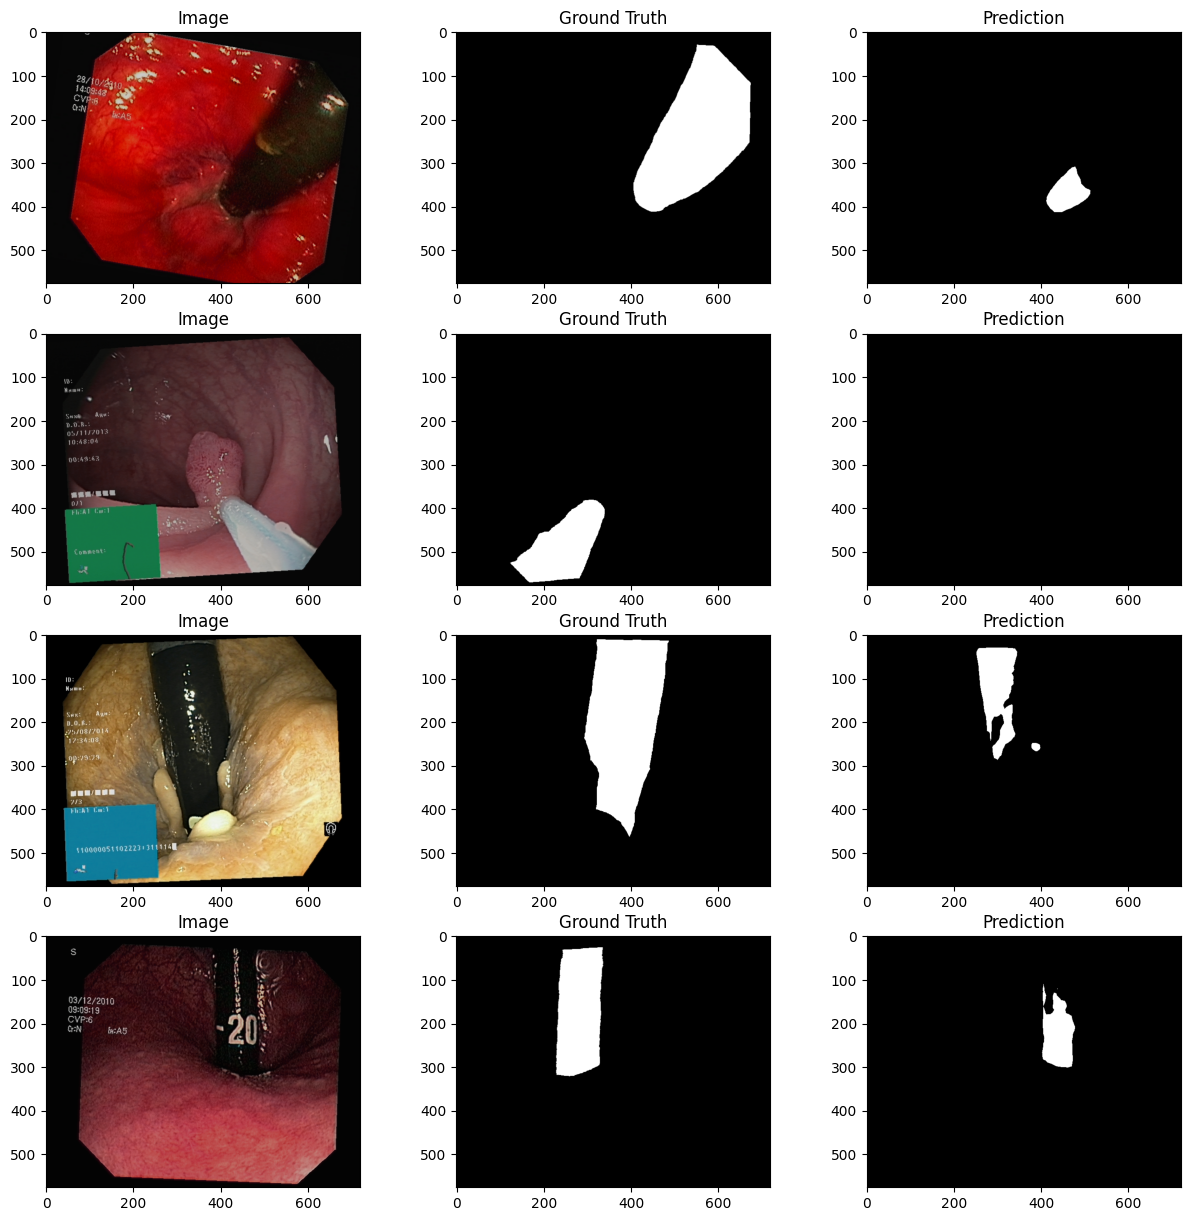

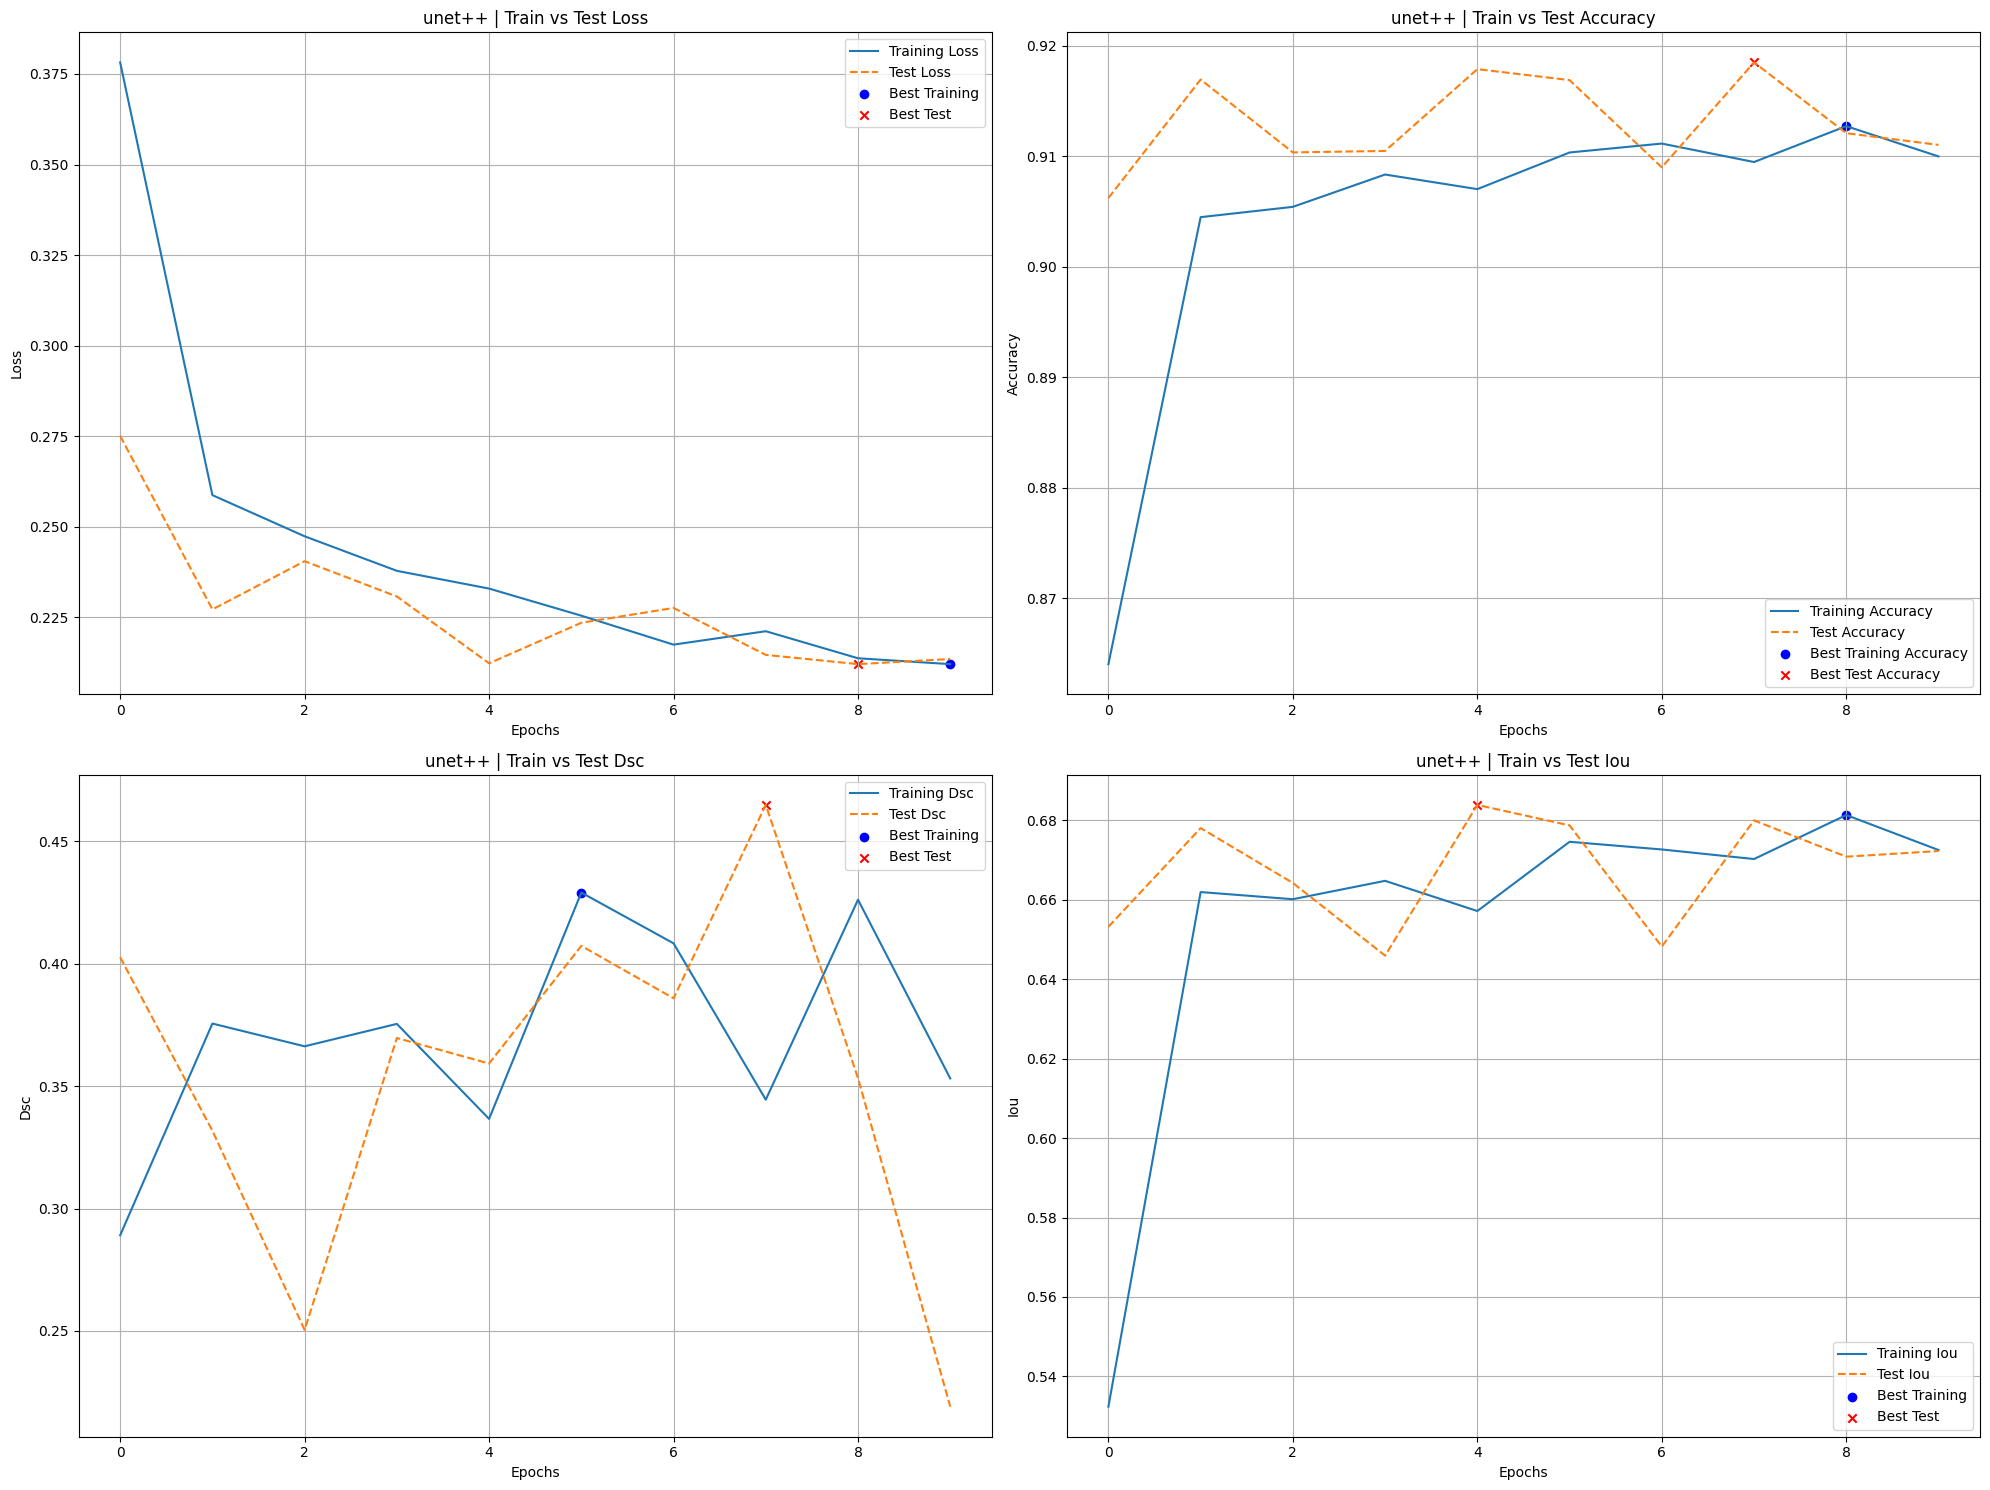


Best Results:
------------------------------------------------------------------------------------------
Model           | Best Loss  | Best Accuracy (%) | Best DSC   | Best IoU  
------------------------------------------------------------------------------------------
unet++          | 0.2135     | 91.10          % | 0.2191     | 0.6723    
------------------------------------------------------------------------------------------


In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR

# Define the augmentation transforms
mask_augmented_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize((576, 720)),
    transforms.ToTensor(),
])

image_augmented_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.Resize((576, 720)),
    transforms.ToTensor(),
])

# Create the augmented data loaders
training_data_augmented = KvasirInstrument(root="data", train=True, download=False, transform=image_augmented_transform, target_transform=mask_augmented_transform)
train_loader_augmented = DataLoader(training_data_augmented, batch_size=4, shuffle=True)

test_data = KvasirInstrument(root="data", train=False, download=False, transform=image_augmented_transform, target_transform=mask_augmented_transform)
test_loader = DataLoader(test_data, batch_size=4, shuffle=False)

def train_and_evaluate_models(train_loader, test_loader, device='cuda'):
    # Hyperparameters
    input_size = (576, 720)
    out_channels = 1
    batch_size = 4
    visualized = False


    # Define models with ReLU activation
    models = {
        'unet++': get_model('unet++', 3, out_channels, activation_fn=nn.ReLU),
    }


    # Ref.: https://machinelearningmastery.com/activation-functions-in-pytorch/
    # Initialize results storage
    results = {}
    best_results = {}
    for name, model in models.items():
        print(f"\nTraining model: {name}")
        model.to(device)

        criterion = torch.nn.BCEWithLogitsLoss()
        # use Learning-rate scheduler
        optimizer = optim.Adam(model.parameters(), lr=1e-4) # can reduce the lr to 1e-4, 1e-8 ...
        scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
        early_stopping = EarlyStopping(patience=5, verbose=True, activation_name=name)

        # Initilize the train and test storage list
        train_loss_history = []
        train_accuracy_history = []
        test_accuracy_history = []
        train_dsc_history = []
        test_dsc_history = []
        train_iou_history = []
        test_iou_history = []
        test_loss_history = []

        # Variables to save the best images, ground truths and predictions
        best_images, best_ground_truths = next(iter(test_loader))
        best_images, best_ground_truths = best_images.to(device), best_ground_truths.to(device)
        best_predictions = None

        # Initialize best metrics
        best_loss = float('inf')
        best_accuracy = 0.0
        best_dsc = 0.0
        best_iou = 0.0
        epoch = 0

        while not early_stopping.early_stop:
            # use different learning rates to train the model
            train_loss, train_accuracy, train_dsc, train_iou = train(train_loader, model, criterion, optimizer, device)
            test_loss, test_accuracy, test_dsc, test_iou = test(test_loader, model, criterion, device)

            # Append to the lists
            train_loss_history.append(train_loss)
            test_loss_history.append(test_loss)
            train_accuracy_history.append(train_accuracy)
            test_accuracy_history.append(test_accuracy)
            train_dsc_history.append(train_dsc)
            test_dsc_history.append(test_dsc)
            train_iou_history.append(train_iou)
            test_iou_history.append(test_iou)

            early_stopping(test_loss, test_accuracy, test_dsc, test_iou, model)
            if early_stopping.early_stop:
                print('Early stopping')
                break
            scheduler.step()
            epoch += 1

            print(f"Epoch {epoch} => "
                  f"Training Loss: {train_loss:.4f} - "
                  f"Training Accuracy: {train_accuracy*100:.2f}% - "
                  f"Test Loss: {test_loss:.4f} - "
                  f"Test Accuracy: {test_accuracy*100:.2f}% - "
                  f"Training DSC: {train_dsc:.4f} - "
                  f"Test DSC: {test_dsc:.4f} - "
                  f"Training IoU: {train_iou:.4f} - "
                  f"Test IoU: {test_iou:.4f}")

        # Save the best model based on IoU
        if test_iou > best_iou:
            best_loss = test_loss
            best_accuracy = test_accuracy
            best_dsc = test_dsc
            best_iou = test_iou
            torch.save(model.state_dict(), f'best_checkpoint_{name}.pt')

        results[name] = {
            'train_loss_history': train_loss_history,
            'test_loss_history': test_loss_history,
            'train_accuracy_history': train_accuracy_history,
            'test_accuracy_history': test_accuracy_history,
            'train_dsc_history': train_dsc_history,
            'test_dsc_history': test_dsc_history,
            'train_iou_history': train_iou_history,
            'test_iou_history': test_iou_history
        }

        best_results[name] = {
            'Best Loss': best_loss,
            'Best Accuracy': best_accuracy,
            'Best DSC': best_dsc,
            'Best IoU': best_iou
        }

        # Save the batch images, ground truths, and predictions
        # Ref.: https://github.com/qubvel/segmentation_models.pytorch/blob/master/examples/binary_segmentation_intro.ipynb
        with torch.no_grad():
          for i, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            predictions = torch.sigmoid(outputs) > 0.5

            # Save the first batch of images, ground truth, and predictions
            if i == 0:
              best_images = inputs
              best_ground_truths = targets
              best_predictions = predictions
            break

    # Display images, ground truth, and predictions for the best checkpoint of the current activation
    if best_predictions is not None:
      visualize_samples(best_images, best_ground_truths, best_predictions, epoch, device)
    else:
      print(f'No best predictions for activation: {name}.')

    # Visualization for each model
    for name, data in results.items():
        plt.figure(figsize=(20, 15))
        metrics = ['loss', 'accuracy', 'dsc', 'iou']
        for i, metric in enumerate(metrics):
            plt.subplot(2, 2, i+1)
            plt.subplot(2, 2, i+1)
            plt.plot(data[f'train_{metric}_history'], label=f'Training {metric.capitalize()}')
            plt.plot(data[f'test_{metric}_history'], '--', label=f'Test {metric.capitalize()}')

            if metric in ['loss', 'dsc', 'iou']:
                best_train_idx = np.argmin(data[f'train_{metric}_history']) if metric == 'loss' else np.argmax(data[f'train_{metric}_history'])
                best_test_idx = np.argmin(data[f'test_{metric}_history']) if metric == 'loss' else np.argmax(data[f'test_{metric}_history'])
                plt.scatter(best_train_idx, data[f'train_{metric}_history'][best_train_idx], color='blue', marker='o', label='Best Training')
                plt.scatter(best_test_idx, data[f'test_{metric}_history'][best_test_idx], color='red', marker='x', label='Best Test')
            else:
                best_train_acc_idx = np.argmax(data['train_accuracy_history'])
                best_test_acc_idx = np.argmax(data['test_accuracy_history'])
                plt.scatter(best_train_acc_idx, data['train_accuracy_history'][best_train_acc_idx], color='blue', marker='o', label='Best Training Accuracy')
                plt.scatter(best_test_acc_idx, data['test_accuracy_history'][best_test_acc_idx], color='red', marker='x', label='Best Test Accuracy')

            plt.xlabel('Epochs')
            plt.ylabel(metric.capitalize())
            plt.title(f'{name} | Train vs Test {metric.capitalize()}')
            plt.legend()
            plt.grid()

        plt.tight_layout()
        plt.show()

    # Print the best results in a table format for each model
    print('\nBest Results:')
    print('-' * 90)
    # Add headers here with "Model" instead of "Activation"
    print("{:<15} | {:<10} | {:<15} | {:<10} | {:<10}".format('Model', 'Best Loss', 'Best Accuracy (%)', 'Best DSC', 'Best IoU'))
    print('-' * 90)
    for key, value in best_results.items():
      print("{:<15} | {:<10.4f} | {:<15.2f}% | {:<10.4f} | {:<10.4f}".format(key, value["Best Loss"], value["Best Accuracy"]*100, value["Best DSC"], value["Best IoU"]))
    print("-" * 90)

# Usage
train_and_evaluate_models(train_loader_augmented, test_loader)

**FPN without Augmentation │ RELU │ Adam**


Training model: fpn
Test IoU increased  0.668312 -->  0.668312. Saving model......
Epoch 1 => Training Loss: 0.1207 - Training Accuracy: 95.15% - Test Loss: 0.3558 - Test Accuracy: 91.39% - Training DSC: 0.7562 - Test DSC: 0.5136 - Training IoU: 0.8210 - Test IoU: 0.6683
EarlyStopping counter: 1 out of 5
Epoch 2 => Training Loss: 0.0482 - Training Accuracy: 98.17% - Test Loss: 0.5015 - Test Accuracy: 89.42% - Training DSC: 0.9008 - Test DSC: 0.3779 - Training IoU: 0.9031 - Test IoU: 0.6166
EarlyStopping counter: 2 out of 5
Epoch 3 => Training Loss: 0.0351 - Training Accuracy: 98.65% - Test Loss: 0.5085 - Test Accuracy: 89.84% - Training DSC: 0.9294 - Test DSC: 0.3746 - Training IoU: 0.9231 - Test IoU: 0.6288
EarlyStopping counter: 3 out of 5
Epoch 4 => Training Loss: 0.0245 - Training Accuracy: 99.04% - Test Loss: 0.6329 - Test Accuracy: 89.59% - Training DSC: 0.9486 - Test DSC: 0.4038 - Training IoU: 0.9408 - Test IoU: 0.6237
EarlyStopping counter: 4 out of 5
Epoch 5 => Training Loss

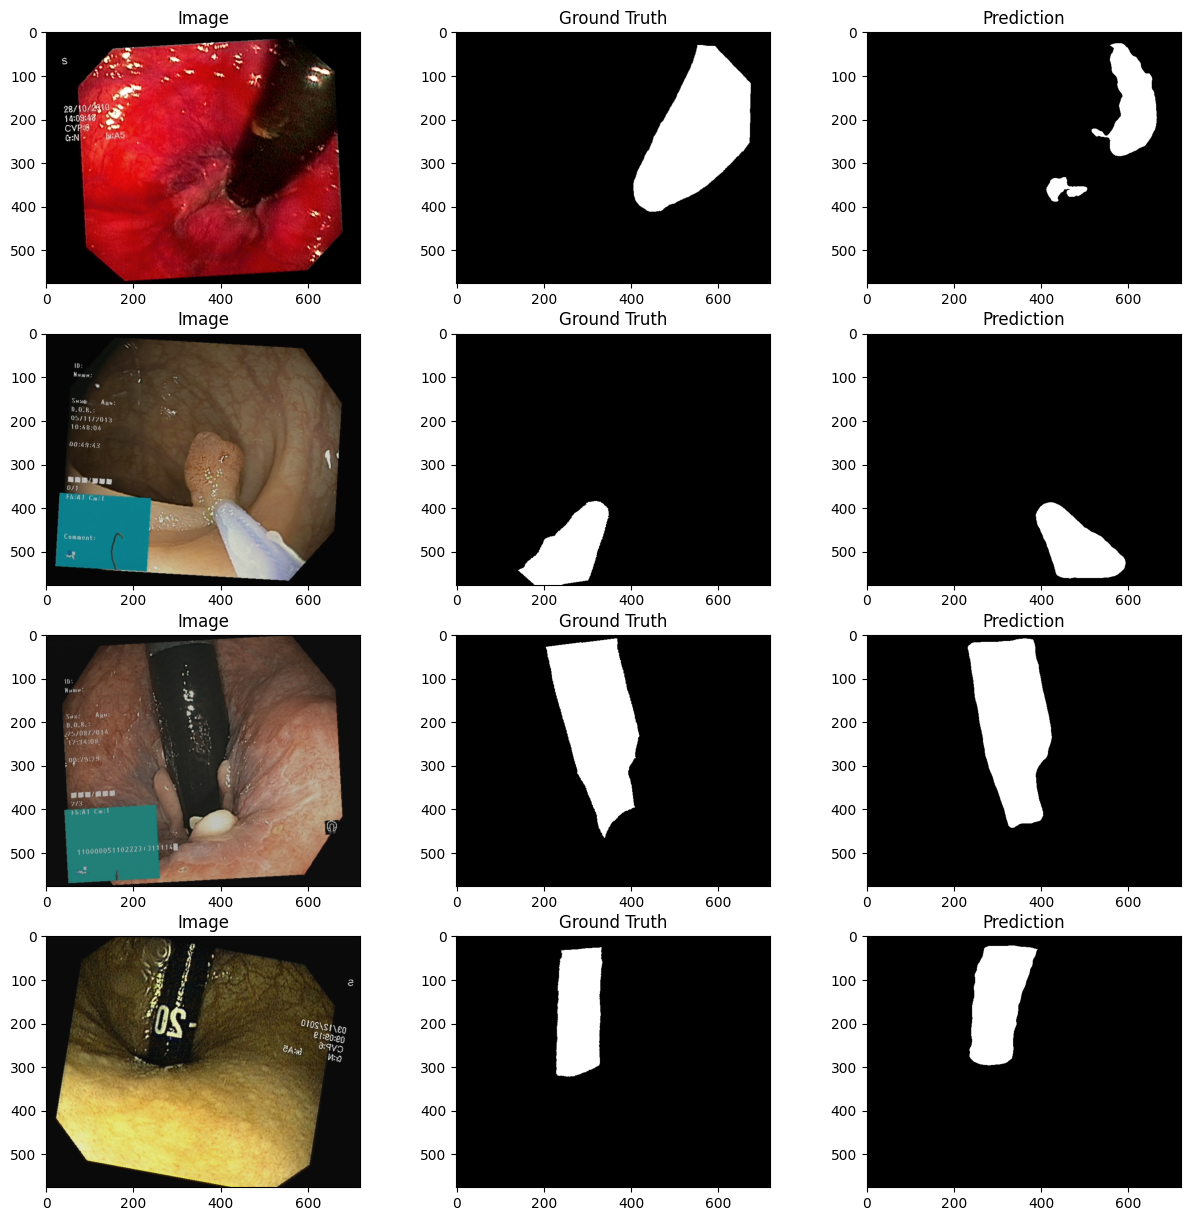

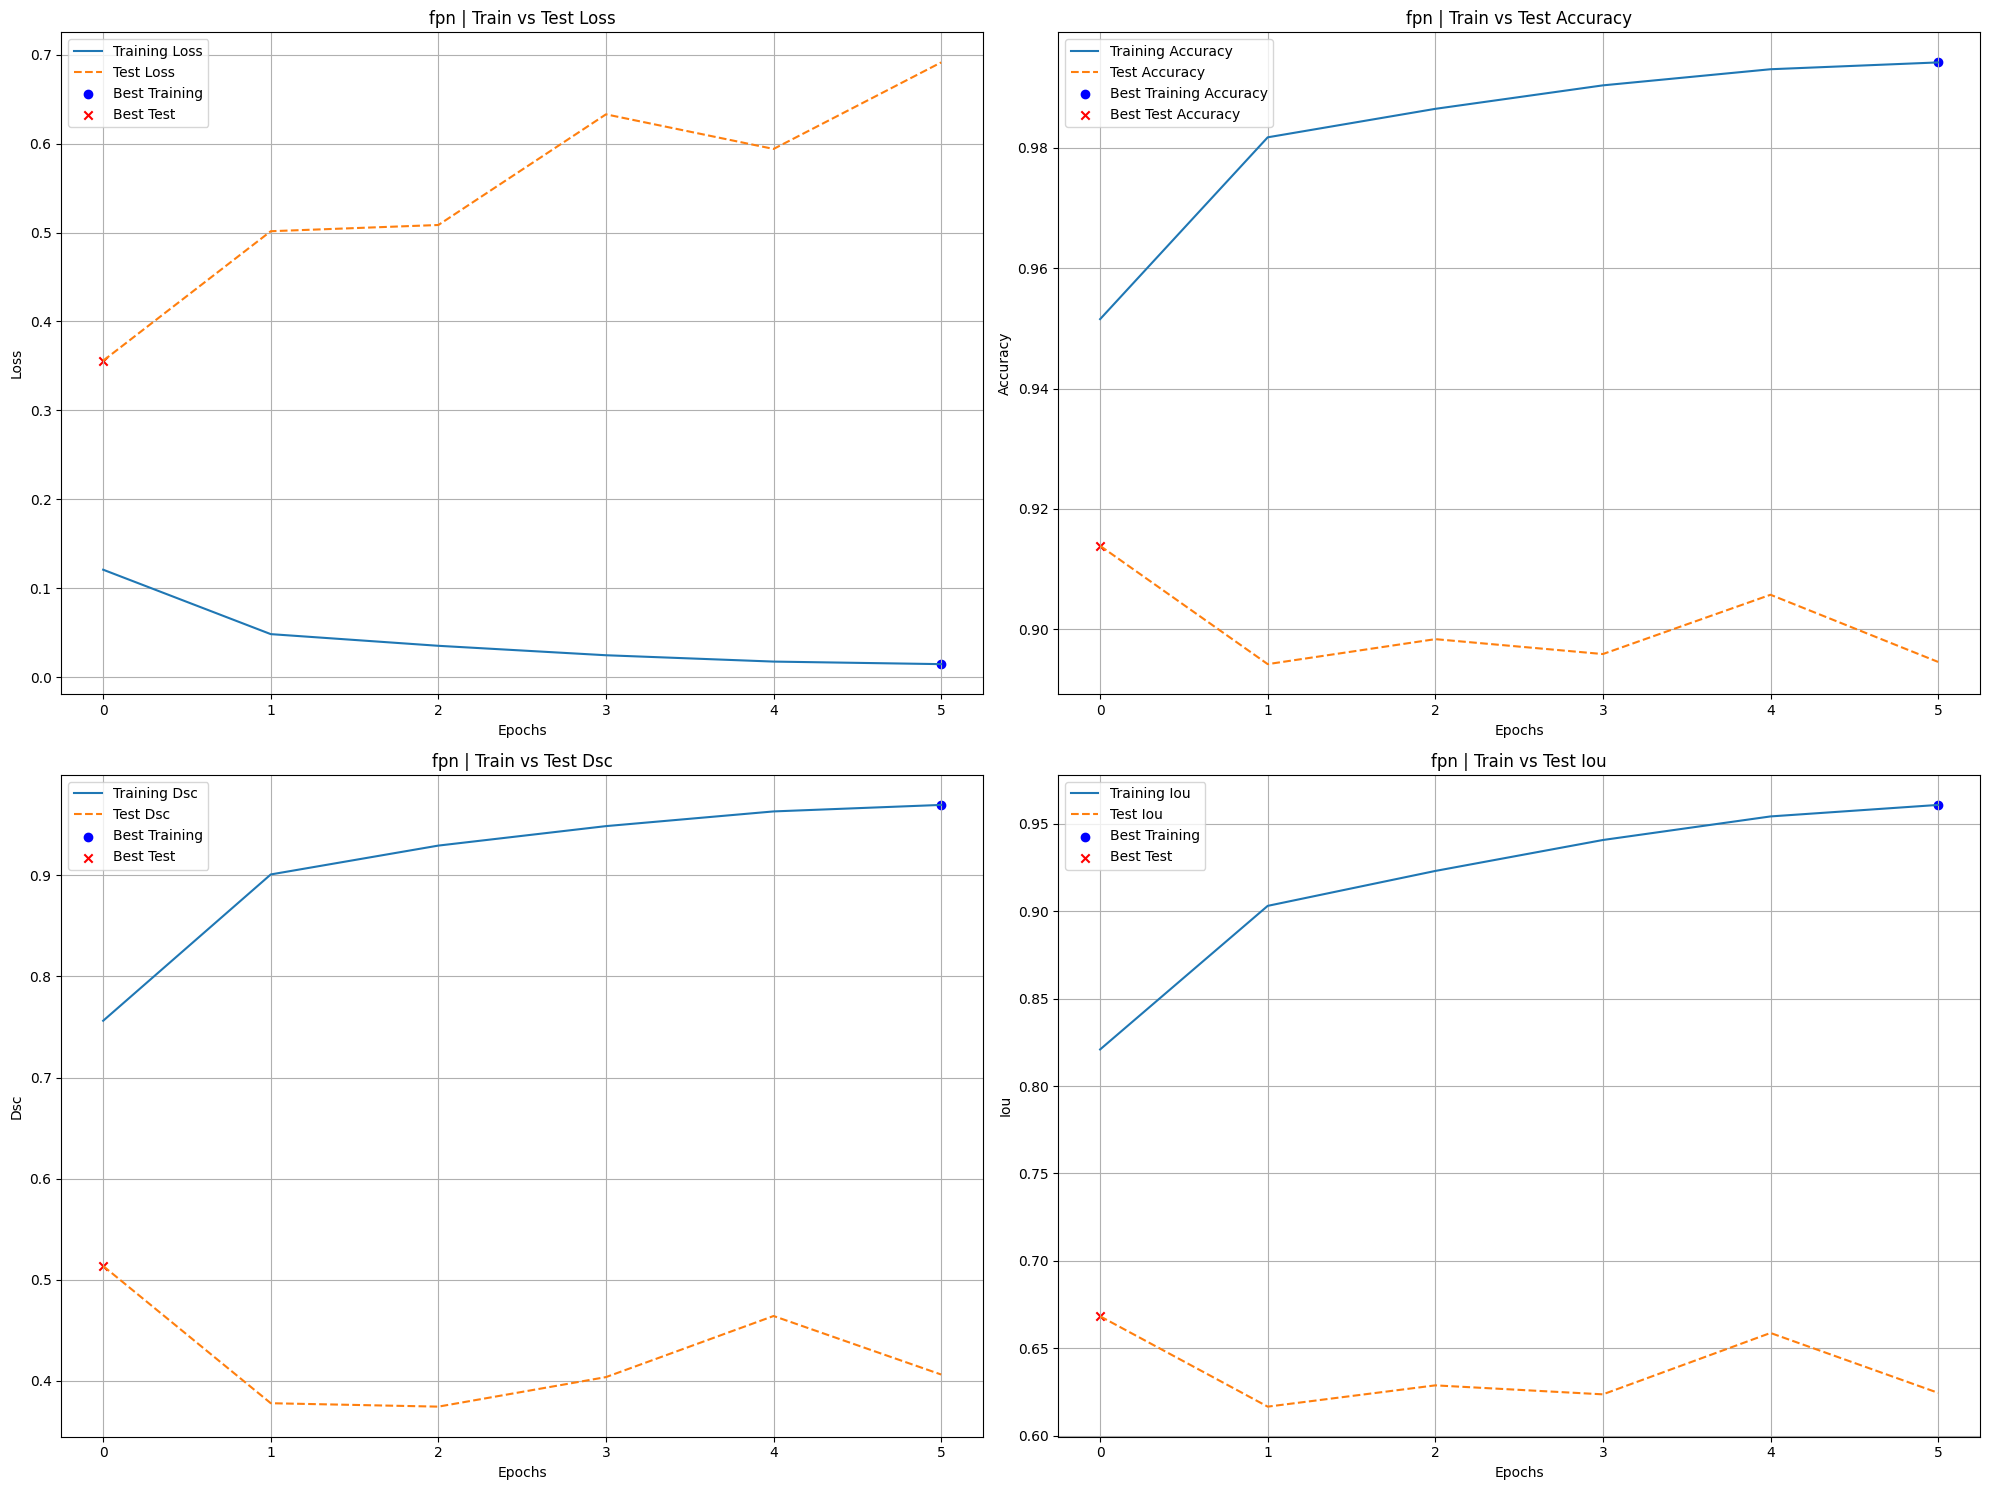


Best Results:
------------------------------------------------------------------------------------------
Model           | Best Loss  | Best Accuracy (%) | Best DSC   | Best IoU  
------------------------------------------------------------------------------------------
fpn             | 0.6913     | 89.46          % | 0.4063     | 0.6245    
------------------------------------------------------------------------------------------


In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR

def train_and_evaluate_models(train_loader, test_loader, device='cuda'):
    # Hyperparameters
    input_size = (576, 720)
    out_channels = 1
    batch_size = 4
    visualized = False


    # Define models with ReLU activation
    models = {
        'fpn': get_model('fpn', 3, out_channels, activation_fn=nn.ReLU),
    }


    # Ref.: https://machinelearningmastery.com/activation-functions-in-pytorch/
    # Initialize results storage
    results = {}
    best_results = {}
    for name, model in models.items():
        print(f"\nTraining model: {name}")
        model.to(device)

        criterion = torch.nn.BCEWithLogitsLoss()
        # use Learning-rate scheduler
        optimizer = optim.Adam(model.parameters(), lr=1e-4) # can reduce the lr to 1e-4, 1e-8 ...
        scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
        early_stopping = EarlyStopping(patience=5, verbose=True, activation_name=name)

        # Initilize the train and test storage list
        train_loss_history = []
        train_accuracy_history = []
        test_accuracy_history = []
        train_dsc_history = []
        test_dsc_history = []
        train_iou_history = []
        test_iou_history = []
        test_loss_history = []

        # Variables to save the best images, ground truths and predictions
        best_images, best_ground_truths = next(iter(test_loader))
        best_images, best_ground_truths = best_images.to(device), best_ground_truths.to(device)
        best_predictions = None

        # Initialize best metrics
        best_loss = float('inf')
        best_accuracy = 0.0
        best_dsc = 0.0
        best_iou = 0.0
        epoch = 0

        while not early_stopping.early_stop:
            # use different learning rates to train the model
            train_loss, train_accuracy, train_dsc, train_iou = train(train_loader, model, criterion, optimizer, device)
            test_loss, test_accuracy, test_dsc, test_iou = test(test_loader, model, criterion, device)

            # Append to the lists
            train_loss_history.append(train_loss)
            test_loss_history.append(test_loss)
            train_accuracy_history.append(train_accuracy)
            test_accuracy_history.append(test_accuracy)
            train_dsc_history.append(train_dsc)
            test_dsc_history.append(test_dsc)
            train_iou_history.append(train_iou)
            test_iou_history.append(test_iou)

            early_stopping(test_loss, test_accuracy, test_dsc, test_iou, model)
            if early_stopping.early_stop:
                print('Early stopping')
                break
            scheduler.step()
            epoch += 1

            print(f"Epoch {epoch} => "
                  f"Training Loss: {train_loss:.4f} - "
                  f"Training Accuracy: {train_accuracy*100:.2f}% - "
                  f"Test Loss: {test_loss:.4f} - "
                  f"Test Accuracy: {test_accuracy*100:.2f}% - "
                  f"Training DSC: {train_dsc:.4f} - "
                  f"Test DSC: {test_dsc:.4f} - "
                  f"Training IoU: {train_iou:.4f} - "
                  f"Test IoU: {test_iou:.4f}")

        # Save the best model based on IoU
        if test_iou > best_iou:
            best_loss = test_loss
            best_accuracy = test_accuracy
            best_dsc = test_dsc
            best_iou = test_iou
            torch.save(model.state_dict(), f'best_checkpoint_{name}.pt')

        results[name] = {
            'train_loss_history': train_loss_history,
            'test_loss_history': test_loss_history,
            'train_accuracy_history': train_accuracy_history,
            'test_accuracy_history': test_accuracy_history,
            'train_dsc_history': train_dsc_history,
            'test_dsc_history': test_dsc_history,
            'train_iou_history': train_iou_history,
            'test_iou_history': test_iou_history
        }

        best_results[name] = {
            'Best Loss': best_loss,
            'Best Accuracy': best_accuracy,
            'Best DSC': best_dsc,
            'Best IoU': best_iou
        }

        # Save the batch images, ground truths, and predictions
        # Ref.: https://github.com/qubvel/segmentation_models.pytorch/blob/master/examples/binary_segmentation_intro.ipynb
        with torch.no_grad():
          for i, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            predictions = torch.sigmoid(outputs) > 0.5

            # Save the first batch of images, ground truth, and predictions
            if i == 0:
              best_images = inputs
              best_ground_truths = targets
              best_predictions = predictions
            break

    # Display images, ground truth, and predictions for the best checkpoint of the current activation
    if best_predictions is not None:
      visualize_samples(best_images, best_ground_truths, best_predictions, epoch, device)
    else:
      print(f'No best predictions for activation: {name}.')

    # Visualization for each model
    for name, data in results.items():
        plt.figure(figsize=(20, 15))
        metrics = ['loss', 'accuracy', 'dsc', 'iou']
        for i, metric in enumerate(metrics):
            plt.subplot(2, 2, i+1)
            plt.subplot(2, 2, i+1)
            plt.plot(data[f'train_{metric}_history'], label=f'Training {metric.capitalize()}')
            plt.plot(data[f'test_{metric}_history'], '--', label=f'Test {metric.capitalize()}')

            if metric in ['loss', 'dsc', 'iou']:
                best_train_idx = np.argmin(data[f'train_{metric}_history']) if metric == 'loss' else np.argmax(data[f'train_{metric}_history'])
                best_test_idx = np.argmin(data[f'test_{metric}_history']) if metric == 'loss' else np.argmax(data[f'test_{metric}_history'])
                plt.scatter(best_train_idx, data[f'train_{metric}_history'][best_train_idx], color='blue', marker='o', label='Best Training')
                plt.scatter(best_test_idx, data[f'test_{metric}_history'][best_test_idx], color='red', marker='x', label='Best Test')
            else:
                best_train_acc_idx = np.argmax(data['train_accuracy_history'])
                best_test_acc_idx = np.argmax(data['test_accuracy_history'])
                plt.scatter(best_train_acc_idx, data['train_accuracy_history'][best_train_acc_idx], color='blue', marker='o', label='Best Training Accuracy')
                plt.scatter(best_test_acc_idx, data['test_accuracy_history'][best_test_acc_idx], color='red', marker='x', label='Best Test Accuracy')

            plt.xlabel('Epochs')
            plt.ylabel(metric.capitalize())
            plt.title(f'{name} | Train vs Test {metric.capitalize()}')
            plt.legend()
            plt.grid()

        plt.tight_layout()
        plt.show()

    # Print the best results in a table format for each model
    print('\nBest Results:')
    print('-' * 90)
    # Add headers here with "Model" instead of "Activation"
    print("{:<15} | {:<10} | {:<15} | {:<10} | {:<10}".format('Model', 'Best Loss', 'Best Accuracy (%)', 'Best DSC', 'Best IoU'))
    print('-' * 90)
    for key, value in best_results.items():
      print("{:<15} | {:<10.4f} | {:<15.2f}% | {:<10.4f} | {:<10.4f}".format(key, value["Best Loss"], value["Best Accuracy"]*100, value["Best DSC"], value["Best IoU"]))
    print("-" * 90)

# Usage
train_and_evaluate_models(train_loader, test_loader)

**FPN with Augmentation │ RELU │ Adam**


Training model: fpn
Test IoU increased  0.671813 -->  0.671813. Saving model......
Epoch 1 => Training Loss: 0.2853 - Training Accuracy: 89.55% - Test Loss: 0.2268 - Test Accuracy: 91.76% - Training DSC: 0.1324 - Test DSC: 0.4363 - Training IoU: 0.6401 - Test IoU: 0.6718
Test IoU increased  0.675539 -->  0.675539. Saving model......
Epoch 2 => Training Loss: 0.2528 - Training Accuracy: 89.97% - Test Loss: 0.2281 - Test Accuracy: 91.23% - Training DSC: 0.2256 - Test DSC: 0.1946 - Training IoU: 0.6462 - Test IoU: 0.6755
Test IoU increased  0.681922 -->  0.681922. Saving model......
Epoch 3 => Training Loss: 0.2401 - Training Accuracy: 90.73% - Test Loss: 0.2191 - Test Accuracy: 91.61% - Training DSC: 0.3097 - Test DSC: 0.3992 - Training IoU: 0.6733 - Test IoU: 0.6819
Test IoU increased  0.684524 -->  0.684524. Saving model......
Epoch 4 => Training Loss: 0.2237 - Training Accuracy: 91.17% - Test Loss: 0.2101 - Test Accuracy: 91.44% - Training DSC: 0.3808 - Test DSC: 0.4265 - Training Io

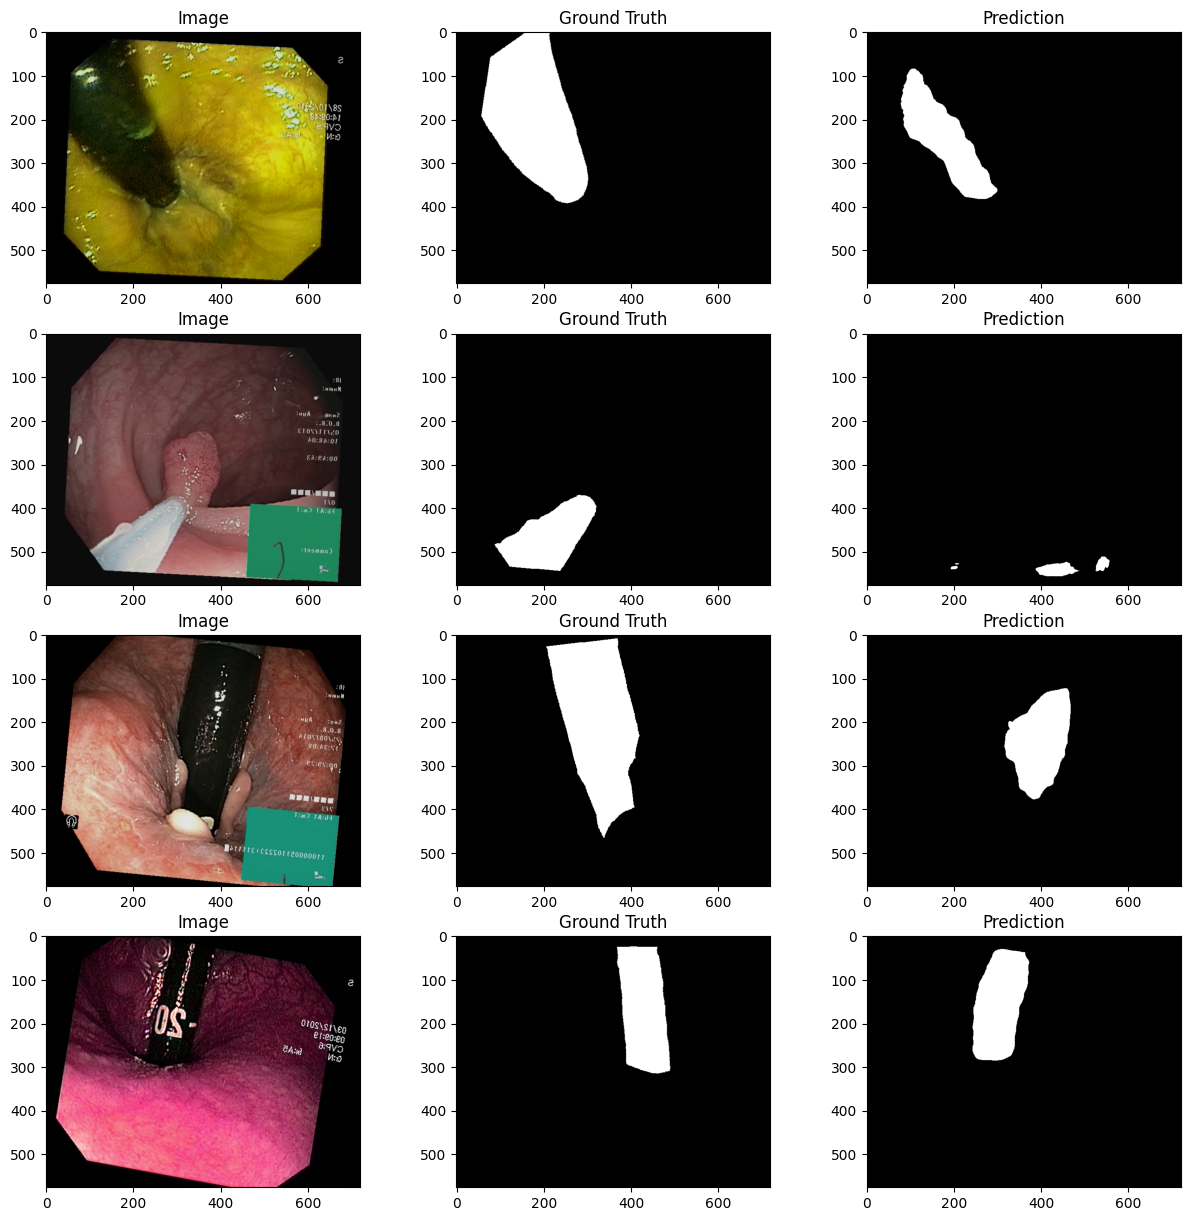

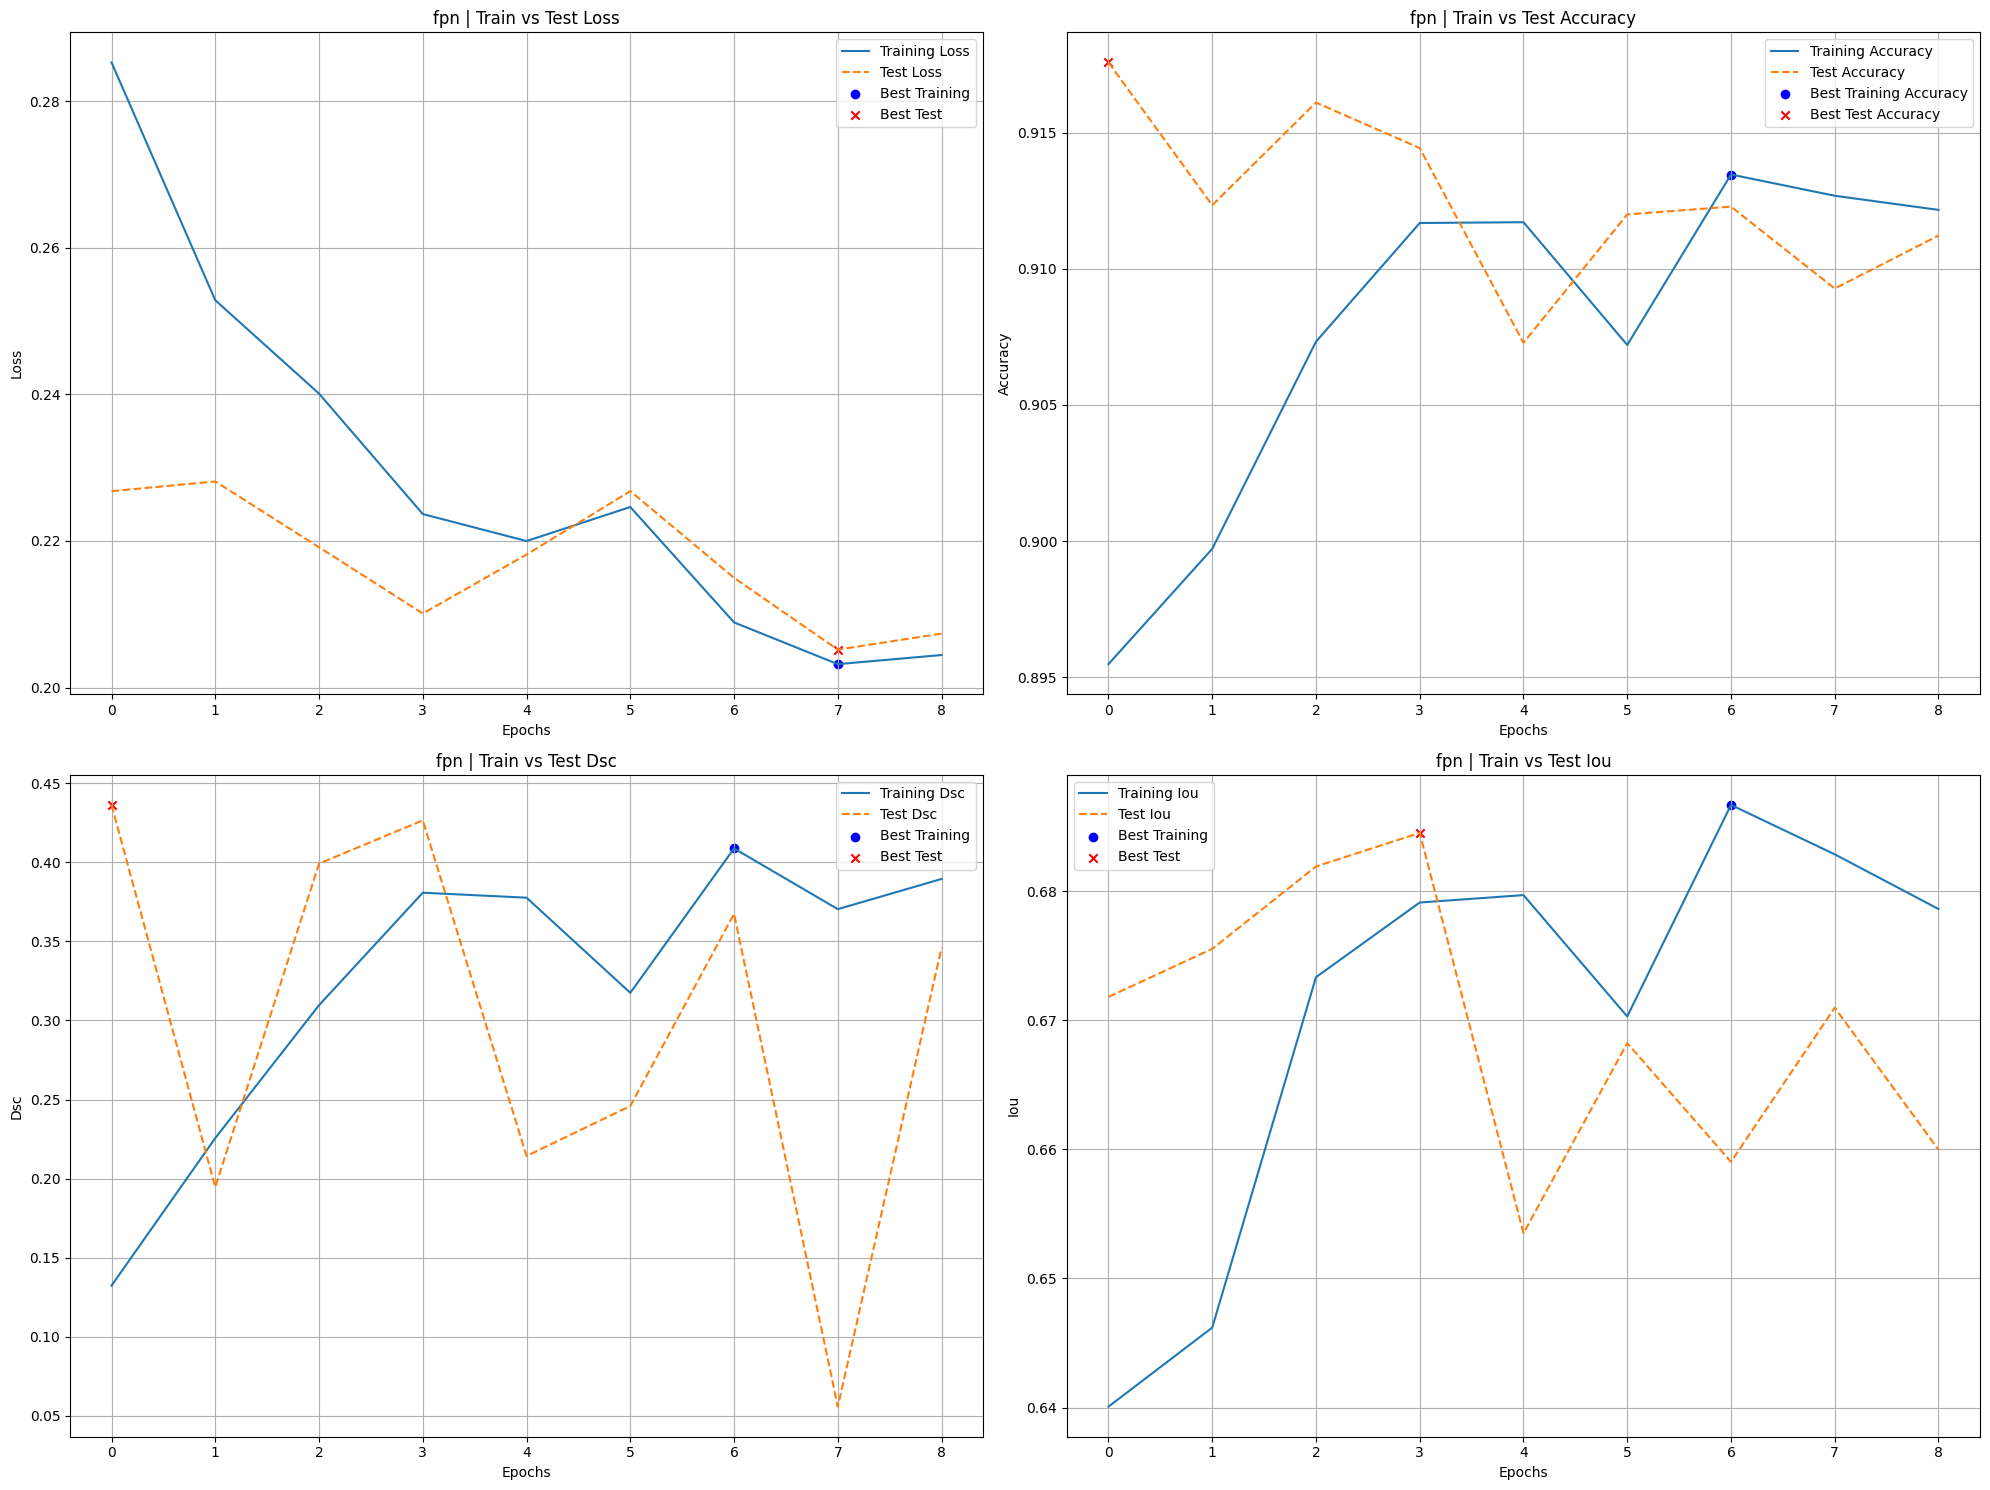


Best Results:
------------------------------------------------------------------------------------------
Model           | Best Loss  | Best Accuracy (%) | Best DSC   | Best IoU  
------------------------------------------------------------------------------------------
fpn             | 0.2074     | 91.12          % | 0.3460     | 0.6600    
------------------------------------------------------------------------------------------


In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR

# Define the augmentation transforms
mask_augmented_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize((576, 720)),
    transforms.ToTensor(),
])

image_augmented_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.Resize((576, 720)),
    transforms.ToTensor(),
])

# Create the augmented data loaders
training_data_augmented = KvasirInstrument(root="data", train=True, download=False, transform=image_augmented_transform, target_transform=mask_augmented_transform)
train_loader_augmented = DataLoader(training_data_augmented, batch_size=4, shuffle=True)

test_data = KvasirInstrument(root="data", train=False, download=False, transform=image_augmented_transform, target_transform=mask_augmented_transform)
test_loader = DataLoader(test_data, batch_size=4, shuffle=False)

def train_and_evaluate_models(train_loader, test_loader, device='cuda'):
    # Hyperparameters
    input_size = (576, 720)
    out_channels = 1
    batch_size = 4
    visualized = False


    # Define models with ReLU activation
    models = {
        'fpn': get_model('fpn', 3, out_channels, activation_fn=nn.ReLU),
    }


    # Ref.: https://machinelearningmastery.com/activation-functions-in-pytorch/
    # Initialize results storage
    results = {}
    best_results = {}
    for name, model in models.items():
        print(f"\nTraining model: {name}")
        model.to(device)

        criterion = torch.nn.BCEWithLogitsLoss()
        # use Learning-rate scheduler
        optimizer = optim.Adam(model.parameters(), lr=1e-4) # can reduce the lr to 1e-4, 1e-8 ...
        scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
        early_stopping = EarlyStopping(patience=5, verbose=True, activation_name=name)

        # Initilize the train and test storage list
        train_loss_history = []
        train_accuracy_history = []
        test_accuracy_history = []
        train_dsc_history = []
        test_dsc_history = []
        train_iou_history = []
        test_iou_history = []
        test_loss_history = []

        # Variables to save the best images, ground truths and predictions
        best_images, best_ground_truths = next(iter(test_loader))
        best_images, best_ground_truths = best_images.to(device), best_ground_truths.to(device)
        best_predictions = None

        # Initialize best metrics
        best_loss = float('inf')
        best_accuracy = 0.0
        best_dsc = 0.0
        best_iou = 0.0
        epoch = 0

        while not early_stopping.early_stop:
            # use different learning rates to train the model
            train_loss, train_accuracy, train_dsc, train_iou = train(train_loader, model, criterion, optimizer, device)
            test_loss, test_accuracy, test_dsc, test_iou = test(test_loader, model, criterion, device)

            # Append to the lists
            train_loss_history.append(train_loss)
            test_loss_history.append(test_loss)
            train_accuracy_history.append(train_accuracy)
            test_accuracy_history.append(test_accuracy)
            train_dsc_history.append(train_dsc)
            test_dsc_history.append(test_dsc)
            train_iou_history.append(train_iou)
            test_iou_history.append(test_iou)

            early_stopping(test_loss, test_accuracy, test_dsc, test_iou, model)
            if early_stopping.early_stop:
                print('Early stopping')
                break
            scheduler.step()
            epoch += 1

            print(f"Epoch {epoch} => "
                  f"Training Loss: {train_loss:.4f} - "
                  f"Training Accuracy: {train_accuracy*100:.2f}% - "
                  f"Test Loss: {test_loss:.4f} - "
                  f"Test Accuracy: {test_accuracy*100:.2f}% - "
                  f"Training DSC: {train_dsc:.4f} - "
                  f"Test DSC: {test_dsc:.4f} - "
                  f"Training IoU: {train_iou:.4f} - "
                  f"Test IoU: {test_iou:.4f}")

        # Save the best model based on IoU
        if test_iou > best_iou:
            best_loss = test_loss
            best_accuracy = test_accuracy
            best_dsc = test_dsc
            best_iou = test_iou
            torch.save(model.state_dict(), f'best_checkpoint_{name}.pt')

        results[name] = {
            'train_loss_history': train_loss_history,
            'test_loss_history': test_loss_history,
            'train_accuracy_history': train_accuracy_history,
            'test_accuracy_history': test_accuracy_history,
            'train_dsc_history': train_dsc_history,
            'test_dsc_history': test_dsc_history,
            'train_iou_history': train_iou_history,
            'test_iou_history': test_iou_history
        }

        best_results[name] = {
            'Best Loss': best_loss,
            'Best Accuracy': best_accuracy,
            'Best DSC': best_dsc,
            'Best IoU': best_iou
        }

        # Save the batch images, ground truths, and predictions
        # Ref.: https://github.com/qubvel/segmentation_models.pytorch/blob/master/examples/binary_segmentation_intro.ipynb
        with torch.no_grad():
          for i, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            predictions = torch.sigmoid(outputs) > 0.5

            # Save the first batch of images, ground truth, and predictions
            if i == 0:
              best_images = inputs
              best_ground_truths = targets
              best_predictions = predictions
            break

    # Display images, ground truth, and predictions for the best checkpoint of the current activation
    if best_predictions is not None:
      visualize_samples(best_images, best_ground_truths, best_predictions, epoch, device)
    else:
      print(f'No best predictions for activation: {name}.')

    # Visualization for each model
    for name, data in results.items():
        plt.figure(figsize=(20, 15))
        metrics = ['loss', 'accuracy', 'dsc', 'iou']
        for i, metric in enumerate(metrics):
            plt.subplot(2, 2, i+1)
            plt.subplot(2, 2, i+1)
            plt.plot(data[f'train_{metric}_history'], label=f'Training {metric.capitalize()}')
            plt.plot(data[f'test_{metric}_history'], '--', label=f'Test {metric.capitalize()}')

            if metric in ['loss', 'dsc', 'iou']:
                best_train_idx = np.argmin(data[f'train_{metric}_history']) if metric == 'loss' else np.argmax(data[f'train_{metric}_history'])
                best_test_idx = np.argmin(data[f'test_{metric}_history']) if metric == 'loss' else np.argmax(data[f'test_{metric}_history'])
                plt.scatter(best_train_idx, data[f'train_{metric}_history'][best_train_idx], color='blue', marker='o', label='Best Training')
                plt.scatter(best_test_idx, data[f'test_{metric}_history'][best_test_idx], color='red', marker='x', label='Best Test')
            else:
                best_train_acc_idx = np.argmax(data['train_accuracy_history'])
                best_test_acc_idx = np.argmax(data['test_accuracy_history'])
                plt.scatter(best_train_acc_idx, data['train_accuracy_history'][best_train_acc_idx], color='blue', marker='o', label='Best Training Accuracy')
                plt.scatter(best_test_acc_idx, data['test_accuracy_history'][best_test_acc_idx], color='red', marker='x', label='Best Test Accuracy')

            plt.xlabel('Epochs')
            plt.ylabel(metric.capitalize())
            plt.title(f'{name} | Train vs Test {metric.capitalize()}')
            plt.legend()
            plt.grid()

        plt.tight_layout()
        plt.show()

    # Print the best results in a table format for each model
    print('\nBest Results:')
    print('-' * 90)
    # Add headers here with "Model" instead of "Activation"
    print("{:<15} | {:<10} | {:<15} | {:<10} | {:<10}".format('Model', 'Best Loss', 'Best Accuracy (%)', 'Best DSC', 'Best IoU'))
    print('-' * 90)
    for key, value in best_results.items():
      print("{:<15} | {:<10.4f} | {:<15.2f}% | {:<10.4f} | {:<10.4f}".format(key, value["Best Loss"], value["Best Accuracy"]*100, value["Best DSC"], value["Best IoU"]))
    print("-" * 90)

# Usage
train_and_evaluate_models(train_loader_augmented, test_loader)